# <h1 style="color:red;"><b>John's Swing-Trading Code (Python Translation)<b></h1>

### <h3 style="color:yellow;">Importing modules and packages</h3>

In [1]:
from datetime import datetime, date, timedelta
# from datetime import datetime
from scipy.stats import linregress
import time
import pandas_market_calendars as mcal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import random
import os
from google.cloud import bigquery
from google.oauth2 import service_account
import sys
from tqdm import tqdm  # optional: for a progress bar
import warnings
import schwabdev
from dotenv import load_dotenv
warnings.filterwarnings("ignore")  # silence any pandas SettingWithCopy warnings
import requests
from io import StringIO
import random
import shutil
import subprocess
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from PIL import Image
import re
import json


## <h2 style="color:purple;">Authentication</h2>

### <h3 style="color:yellow;">Authentication for Schwab</h3>

Load environment variables from .env file for authentification purposes

In [2]:
load_dotenv()

True

Set the display options

In [3]:
# Display options
# Set the global float format to 4 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

Create the client object.

In [4]:
app_key = os.getenv('app_key')
app_secret = os.getenv('app_secret')
callback_url = os.getenv('callback_url')

# Print them to verify (avoid printing sensitive info in production)
print(f"App Key: {app_key}")
print(f"App Secret: {app_secret}")
print(f"Callback URL: {callback_url}")

# Now proceed to initialize the client
client = schwabdev.Client(app_key, app_secret, callback_url)
print('Client initialized!')

App Key: 2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150
App Secret: OQGxH0GkD5bAEMA4
Callback URL: https://127.0.0.1
Client initialized!


Use this when in need of updating the refresh token.

In [5]:
# client.update_tokens(force=True)
# client = schwabdev.Client(app_key, app_secret, callback_url)

### <h3 style="color:yellow;">Authentication for GBQ</h3>

Defines `config()` to return the service account key path for a given user (`reese` or `ben`); raises an error for others. Used for BigQuery authentication.

In [6]:
gbq_proj_id = 'stock-chipper-87578' 

def config(username=None):
    if username == 'reese':
        file_dir = "C:/Users/rsmcd/OneDrive/Desktop/Trade Review/stock-chipper-research/"
        credential_file = 'stock-chipper-87578-ec8b427fca6a.json'
    elif username == 'ben':
        file_dir = "C:/Users/benwo/Documents/repos/stock-chipper-app/creds/"
        credential_file = "stock-chipper-87578-b17ad3f7e6e1.json"
    else:
        raise ValueError(f"Unrecognized or missing username: {username}")
    
    return file_dir + credential_file

Selects user credentials based on context: uses CLI argument if run as `__main__`, defaults to `"reese"` otherwise. Falls back to `"reese"` on error. Result (`private_key`) is used for BigQuery authentication.

In [7]:
# Use default when in Jupyter or if __main__ but no args
try:
    if __name__ == "__main__":
        if len(sys.argv) <= 1:
            raise ValueError("No username provided via CLI args")
        private_key = config(sys.argv[1])
    else:
        private_key = config("reese")  # Default for notebook
except Exception as e:
    print("Falling back to default username (reese)")
    private_key = config("reese")

Falling back to default username (reese)


## <h2 style="color:purple;">Defining Functions</h2>

In [8]:
def get_ticker_data(ticker, date_pull_begin=None, local=False, local_folder="local-ticker-data-schwab", credentials_path=None, project_id=None):
    """
    Retrieves historical daily OHLC data for a given ticker, either from a local file or from BigQuery.

    If `local` is True, the function reads the data from a local TSV file under the specified folder.
    Otherwise, it queries the `stocks_candle_1day` table in BigQuery.

    Args:
        ticker (str): The stock ticker symbol to retrieve data for.
        date_pull_begin (datetime-like, optional): The earliest date to pull data from.
            Defaults to two years before today if not provided.
        local (bool): Whether to read from a local file instead of querying BigQuery.
        local_folder (str): Name of the subfolder under 'data/' containing local files.
            Options include "local-ticker-data-gbq" or "local-ticker-data-schwab".
        credentials_path (str, optional): Full path to the GCP service account JSON key.
            Required if `local` is False.
        project_id (str, optional): GCP project ID. Required if `local` is False.

    Returns:
        pd.DataFrame: A DataFrame containing columns ['ticker', 'date_time', 'high', 'low'].

    Raises:
        ValueError: If `credentials_path` or `project_id` is missing when `local` is False.
    """
    if local:
        file_path = Path("strategies/swing-trading/data") / local_folder / f"{ticker}.txt"
        return pd.read_csv(file_path, sep="\t", parse_dates=["date_time"])

    if date_pull_begin is None:
        date_pull_begin = pd.Timestamp.today() - pd.DateOffset(years=2)                             #### hardcoding !!!

    sql = f"""
        SELECT ticker, date_time, open, high, low, close, volume
        FROM `stock-chipper-87578.first_rate.stocks_candle_1day`
        WHERE date_time > '{date_pull_begin:%Y-%m-%d}' AND ticker = '{ticker}'
        ORDER BY date_time ASC
    """

    return run_sql_query(sql, project_id=project_id, credentials_path=credentials_path)

def evaluate_recent_performance(data, month_lookback=3):
    """
    Computes a weighted average of recent evaluation-period returns, giving more
    weight to the most recent months.

    This is used to score the recent performance of a trading strategy over
    the past `month_lookback` months. Each evaluation period is weighted by
    recency: newer periods receive higher weight using the formula
    `weight = 1 / (months_ago + 1)`.

    Args:
        data (pd.DataFrame): Must contain 'evaluation_period_end' (datetime-like) and
            'evaluation_return' (float, can include NaNs).
        month_lookback (int): Number of months to look back from the latest evaluation period.

    Returns:
        float: Weighted average of evaluation returns over the lookback window.
            Returns 0.0 if no qualifying periods exist.
    """
    data = data.copy()                                                                                  # Work on a copy to avoid modifying original
    data["evaluation_period_end"] = pd.to_datetime(data["evaluation_period_end"])                       # Ensure datetime format for filtering

    last_period = data["evaluation_period_end"].max()                                                   # Get the most recent evaluation period
    cutoff = last_period - pd.DateOffset(months=month_lookback)                                         # Calculate earliest period to include in lookback

    recent = data[                                                                                      # Filter to only rows within the lookback window
        (data["evaluation_period_end"] >= cutoff) &
        (data["evaluation_period_end"] <= last_period)
    ][["evaluation_period_end", "evaluation_return"]].copy()                                            # Keep only relevant columns

    if recent.empty:                                                                                   # Return early if no data in lookback window
        return 0.0

    recent["evaluation_return"] = recent["evaluation_return"].fillna(0.0)                               # Replace missing returns with 0

    recent["months_ago"] = ((last_period - recent["evaluation_period_end"]).dt.days / 30) + 1          # Estimate recency in months (approx.)
    recent["wt"] = 1 / recent["months_ago"]                                                             # Assign higher weight to more recent periods
    recent["wt"] = recent["wt"] / recent["wt"].sum()                                                    # Normalize weights to sum to 1

    recent["wtd_returns"] = recent["wt"] * recent["evaluation_return"]                                  # Compute weighted return for each row

    return recent["wtd_returns"].sum()                                                                  # Return the total weighted average

def run_sql_query(sql, project_id, credentials_path=None):
    """
    Executes a SQL query against Google BigQuery using a service account.

    This function creates an authenticated BigQuery client using a local
    service account JSON credentials file, submits the SQL query, waits
    for it to complete, and returns the results as a pandas DataFrame.

    Args:
        sql (str): The SQL query string to be executed.
        project_id (str): The GCP project ID associated with the BigQuery dataset.
        credentials_path (str): Full path to the service account JSON credentials file.

    Returns:
        pd.DataFrame: The query results as a DataFrame. Each column corresponds to a 
                      field in the SELECT statement of the query.

    Raises:
        ValueError: If `credentials_path` is not provided.
    """
    if credentials_path is None:
        raise ValueError("credentials_path must be provided")

    credentials = service_account.Credentials.from_service_account_file(credentials_path)
    client = bigquery.Client(credentials=credentials, project=project_id)

    query_job = client.query(sql)
    result = query_job.result()
    return result.to_dataframe()

## <h2 style="color:purple;">Retrieve Data</h2>

### <h3 style="color:yellow;">Getting data from Schwab</h3>

**Fetching US Equity Tickers from NASDAQ Trader**

The `get_all_tickers()` function retrieves publicly traded US equity tickers.

1. **Data Sources**:

   * NASDAQ-listed: `nasdaqlisted.txt`
   * Other exchanges (NYSE, AMEX, etc.): `otherlisted.txt`

2. **Parsing**:

   * NASDAQ symbols are read and labeled as `"NASDAQ"`.
   * Other symbols are mapped to full exchange names via a code dictionary.

📌 *Uncomment the concat line and comment the line below it to include all exchanges as originally intended.*

In [9]:
def get_all_tickers():
    """
    Fetches all listed US equity tickers from NASDAQ Trader and returns a DataFrame
    with their associated full exchange name.

    Returns:
        pd.DataFrame: DataFrame with columns ['ticker', 'exchange']
    """
    # URLs to fetch data
    nasdaq_url = 'https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt'
    other_url = 'https://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt'

    # Download NASDAQ-listed tickers
    nasdaq_response = requests.get(nasdaq_url)
    nasdaq_data = pd.read_csv(StringIO(nasdaq_response.text), sep='|')
    nasdaq_df = nasdaq_data[['Symbol']].dropna().copy()
    nasdaq_df.columns = ['ticker']
    nasdaq_df['exchange'] = 'NASDAQ'

    # Download other-listed tickers (NYSE, AMEX, etc.)
    other_response = requests.get(other_url)
    other_data = pd.read_csv(StringIO(other_response.text), sep='|')
    other_df = other_data[['ACT Symbol', 'Exchange']].dropna().copy()
    other_df.columns = ['ticker', 'exchange']

    # Map exchange abbreviations to full names
    exchange_map = {
        'A': 'NYSE American',   # Formerly AMEX
        'N': 'NYSE',
        'P': 'NYSE Arca',
        'Z': 'BATS',
        'V': 'IEX'
    }
    other_df['exchange'] = other_df['exchange'].map(exchange_map).fillna('Other')

    # Combine both sources
    # all_tickers_df = pd.concat([nasdaq_df, other_df], ignore_index=True)

    # Combine both sources
    all_tickers_df = nasdaq_df

    return all_tickers_df

all_tickers_schwab = get_all_tickers()
print(f"Retrieved {len(all_tickers_schwab)} tickers.")
print(all_tickers_schwab)

Retrieved 5043 tickers.
                                 ticker exchange
0                                  AACB   NASDAQ
1                                 AACBR   NASDAQ
2                                 AACBU   NASDAQ
3                                  AACG   NASDAQ
4                                  AACI   NASDAQ
...                                 ...      ...
5039                               ZYBT   NASDAQ
5040                               ZYME   NASDAQ
5041                               ZYXI   NASDAQ
5042                                ZZZ   NASDAQ
5043  File Creation Time: 0818202515:41   NASDAQ

[5043 rows x 2 columns]


This block defines and calls a function that randomly selects up to `n` tickers from a given DataFrame of tickers and exchanges.


In [10]:
def select_random_tickers(ticker_df, n=5):
    """
    Randomly selects n tickers from a DataFrame of tickers and exchanges.

    Args:
        ticker_df (pd.DataFrame): DataFrame with columns ['ticker', 'exchange'].
        n (int): Number of tickers to select.

    Returns:
        pd.DataFrame: A DataFrame with n randomly selected tickers.
    """
    return ticker_df.sample(n=min(n, len(ticker_df))).reset_index(drop=True)

schwab_ticker_num = len(all_tickers_schwab)  # Use the total number of tickers available
# schwab_ticker_num = 1000 # Limit to 100 tickers for testing purposes
random_tickers = select_random_tickers(all_tickers_schwab, n=schwab_ticker_num)
print("Randomly selected tickers:")
print(random_tickers[:20])

Randomly selected tickers:
   ticker exchange
0     DXR   NASDAQ
1    TNFA   NASDAQ
2    BCRX   NASDAQ
3   MLECW   NASDAQ
4    LEXX   NASDAQ
5   NYMTN   NASDAQ
6     KWM   NASDAQ
7    HEQQ   NASDAQ
8    SLNG   NASDAQ
9    IXUS   NASDAQ
10   CLFD   NASDAQ
11   HTCR   NASDAQ
12   UEVM   NASDAQ
13   SEPN   NASDAQ
14    RMR   NASDAQ
15   DHAI   NASDAQ
16   GPRF   NASDAQ
17  VLYPO   NASDAQ
18   NWGL   NASDAQ
19  HOLOW   NASDAQ


Combine randomly selected and major tickers into one DataFrame.

In [11]:
big_ticker_list = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
big_tickers = pd.DataFrame({
    'ticker': big_ticker_list,
    'exchange': ['NASDAQ'] * 5
})

# Combine random sample with manually selected big tickers
test_tickers_df = pd.concat([random_tickers, big_tickers], ignore_index=True)

# Deduplicate by 'ticker', keeping the first occurrence
test_tickers_df = test_tickers_df.drop_duplicates(subset='ticker').reset_index(drop=True)

In [12]:
def get_schwab_data_for_last_year(symbol, exchange=None, years=1): # Revert to this working function 1111
    """
    Fetch 1 year of daily price data from the Schwab API.

    Args:
        symbol (str): Ticker symbol to fetch.
        exchange (str, optional): Exchange name to attach to result.

    Returns:
        List[Dict]: List of candle dictionaries with ticker and exchange info.

    Schwab API - Valid Frequency Parameters for `client.price_history()`:
        frequencyType='minute':  frequency = 1, 5, 10, 15, 30
        frequencyType='daily':   frequency = 1
        frequencyType='weekly':  frequency = 1
        frequencyType='monthly': frequency = 1

    Notes:
        - startDate and endDate should be datetime objects. The client handles timestamp conversion.
        - Only minute-level data supports multiple frequency values.
    """
    end = datetime.now()
    start = end - timedelta(days=730)

    all_candles = []

    while start < end:
        window_end = min(start + timedelta(days=730), end)
        start = pd.to_datetime(start)
        window_end = pd.to_datetime(window_end)

        try:
            response = client.price_history(
                symbol=symbol,
                periodType='year',             # Comment out to get intraday candles
                period=years,                      # Comment out to get intraday candles
                frequencyType='daily',         # Changed from 'minute', Change back to get intraday candles
                frequency=1,                   # Changed from 30, Change back to get intraday candles
                # startDate=start,             # Uncomment to get intraday candles
                # endDate=window_end,          # Uncomment to get intraday candles
                needExtendedHoursData=False
            )
            json_data = response.json()

            if 'candles' in json_data and json_data['candles']:
                for candle in json_data['candles']:
                    candle["ticker"] = symbol
                    candle["exchange"] = exchange
                    all_candles.append(candle)
            else:
                print(f"No candles returned for {symbol} in this chunk.")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

        time.sleep(1)
        start = window_end + timedelta(days=1)

    return all_candles


This is for reference to the prior function just up here ^.

In [13]:
        # :param periodType: period type ("day"|"month"|"year"|"ytd")
        # :type periodType: str
        # :param period: period
        # :type period: int

Pull all data and include exchange info from Schwab.

In [14]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S")) # Revert to this working block 1111

all_candles_combined = []
num_tickers = len(test_tickers_df)
print(num_tickers)

for i, (_, row) in enumerate(test_tickers_df.iterrows(), start=1):
    ticker = row['ticker']
    exchange = row['exchange']

    # print(f"[{i}/{num_tickers}] Fetching {ticker} ({exchange})...")
    
    try:
        candles = get_schwab_data_for_last_year(ticker, exchange, years=2)  # Fetch 2 years of data
        all_candles_combined.extend(candles)
        print(f"[{i}/{num_tickers}] {ticker}: {exchange}: Retrieved {len(candles)} candles")
    except Exception as e:
        print(f"Failed to retrieve {ticker}: {e}")

2025-08-18 13:54:44
5043
[1/5043] DXR: NASDAQ: Retrieved 456 candles
[2/5043] TNFA: NASDAQ: Retrieved 267 candles
[3/5043] BCRX: NASDAQ: Retrieved 503 candles
[4/5043] MLECW: NASDAQ: Retrieved 278 candles
[5/5043] LEXX: NASDAQ: Retrieved 503 candles
[6/5043] NYMTN: NASDAQ: Retrieved 503 candles
[7/5043] KWM: NASDAQ: Retrieved 359 candles
[8/5043] HEQQ: NASDAQ: Retrieved 98 candles
[9/5043] SLNG: NASDAQ: Retrieved 487 candles
[10/5043] IXUS: NASDAQ: Retrieved 503 candles
[11/5043] CLFD: NASDAQ: Retrieved 503 candles
[12/5043] HTCR: NASDAQ: Retrieved 503 candles
[13/5043] UEVM: NASDAQ: Retrieved 503 candles
[14/5043] SEPN: NASDAQ: Retrieved 201 candles
[15/5043] RMR: NASDAQ: Retrieved 503 candles
[16/5043] DHAI: NASDAQ: Retrieved 380 candles
[17/5043] GPRF: NASDAQ: Retrieved 260 candles
[18/5043] VLYPO: NASDAQ: Retrieved 501 candles
[19/5043] NWGL: NASDAQ: Retrieved 476 candles
[20/5043] HOLOW: NASDAQ: Retrieved 464 candles
[21/5043] AACBU: NASDAQ: Retrieved 94 candles
[22/5043] MDWD: NA

Convert the combined candle list into a DataFrame, parses timestamps, sorts the data, and then splits it into a dictionary of DataFrames—one per ticker—for easy access and analysis.


In [15]:
daily_format = True

# Convert to DataFrame
candles_df = pd.DataFrame(all_candles_combined)
if daily_format:
    candles_df['date_time'] = pd.to_datetime(candles_df['datetime'], unit='ms').dt.normalize()
else:
    candles_df['date_time'] = pd.to_datetime(candles_df['datetime'], unit='ms')
    
candles_df = candles_df.sort_values(['ticker', 'date_time']).reset_index(drop=True)

# Split candles_df into a dictionary of DataFrames by ticker
candles_dict_schwab = {
    ticker: df.reset_index(drop=True)
    for ticker, df in candles_df.groupby("ticker")
}

display(candles_df)
display(candles_dict_schwab)

open    high     low   close  volume       datetime ticker exchange  date_time
0        9.8800 10.1000  9.8800  9.8800    8365  1744002000000   AACB   NASDAQ 2025-04-07
1        9.9500  9.9500  9.9500  9.9500     144  1744088400000   AACB   NASDAQ 2025-04-08
2        9.9000  9.9000  9.9000  9.9000  125094  1744174800000   AACB   NASDAQ 2025-04-09
3        9.8500  9.9000  9.8500  9.8900  101015  1744261200000   AACB   NASDAQ 2025-04-10
4        9.8800  9.8900  9.8800  9.8850  641672  1744347600000   AACB   NASDAQ 2025-04-11
...         ...     ...     ...     ...     ...            ...    ...      ...        ...
2033933 30.2100 30.2300 30.0200 30.0340    1643  1754888400000    ZZZ   NASDAQ 2025-08-11
2033934 30.2800 30.3328 30.2800 30.3328     176  1754974800000    ZZZ   NASDAQ 2025-08-12
2033935 30.6108 30.6108 30.6108 30.6108      81  1755061200000    ZZZ   NASDAQ 2025-08-13
2033936 30.2765 30.3377 30.2765 30.3377     619  1755147600000    ZZZ   NASDAQ 2025-08-14
2033937 30.6300 30.6300 30.2016 30.2016    1151  1755234000000    ZZZ   NASDAQ 2025-08-15

[2033938 rows x 9 columns]

{'AACB':       open    high     low   close  volume       datetime ticker exchange  date_time
 0   9.8800 10.1000  9.8800  9.8800    8365  1744002000000   AACB   NASDAQ 2025-04-07
 1   9.9500  9.9500  9.9500  9.9500     144  1744088400000   AACB   NASDAQ 2025-04-08
 2   9.9000  9.9000  9.9000  9.9000  125094  1744174800000   AACB   NASDAQ 2025-04-09
 3   9.8500  9.9000  9.8500  9.8900  101015  1744261200000   AACB   NASDAQ 2025-04-10
 4   9.8800  9.8900  9.8800  9.8850  641672  1744347600000   AACB   NASDAQ 2025-04-11
 ..     ...     ...     ...     ...     ...            ...    ...      ...        ...
 70 10.1300 10.1300 10.1300 10.1300     258  1754888400000   AACB   NASDAQ 2025-08-11
 71 10.1300 10.1500 10.1300 10.1400  151619  1754974800000   AACB   NASDAQ 2025-08-12
 72 10.1350 10.1350 10.1300 10.1300   57913  1755061200000   AACB   NASDAQ 2025-08-13
 73 10.1300 10.1400 10.1300 10.1300    3534  1755147600000   AACB   NASDAQ 2025-08-14
 74 10.1300 10.1300 10.1200 10.1250   13247  1

In [16]:
def slice_last_year_from_df(candles_df, end_date):
    """
    Return rows from candles_df whose 'date_time' is within the 1-year window
    ending at `end_date` (inclusive). Assumes candles_df has a 'date_time' column.
    """
    end = pd.to_datetime(end_date)
    start = end - pd.Timedelta(days=365)
    df = candles_df.copy()
    df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
    out = df.loc[(df["date_time"] > start) & (df["date_time"] <= end)]
    return out.sort_values(["ticker", "date_time"]).reset_index(drop=True)

def slice_last_year_from_dict(candles_dict, end_date):
    """
    For each {ticker: DataFrame} in candles_dict, return a new dict with only the rows
    whose 'date_time' falls in the 1-year window ending at `end_date` (inclusive).
    """
    end = pd.to_datetime(end_date)
    start = end - pd.Timedelta(days=365)
    out = {}
    for ticker, df in candles_dict.items():
        if "date_time" not in df.columns:
            continue
        sub = df.copy()
        sub["date_time"] = pd.to_datetime(sub["date_time"], errors="coerce")
        sub = sub.loc[(sub["date_time"] > start) & (sub["date_time"] <= end)]
        out[ticker] = sub.sort_values("date_time").reset_index(drop=True)
    return out

Slice one year from the combined ticker DataFrame and the dictionary of ticker DataFrames up to a chosen end date.

In [17]:
# --- Slice exactly 1 year ending at a chosen date ---
chosen_end_date = datetime.today().strftime("%Y-%m-%d")
# chosen_end_date = "2025-02-14"  # <-- set your end date here (YYYY-MM-DD)

candles_df = slice_last_year_from_df(candles_df, chosen_end_date)
candles_dict_schwab = slice_last_year_from_dict(candles_dict_schwab, chosen_end_date)

display(candles_df)
display(candles_dict_schwab)

open    high     low   close  volume       datetime ticker exchange  date_time
0        9.8800 10.1000  9.8800  9.8800    8365  1744002000000   AACB   NASDAQ 2025-04-07
1        9.9500  9.9500  9.9500  9.9500     144  1744088400000   AACB   NASDAQ 2025-04-08
2        9.9000  9.9000  9.9000  9.9000  125094  1744174800000   AACB   NASDAQ 2025-04-09
3        9.8500  9.9000  9.8500  9.8900  101015  1744261200000   AACB   NASDAQ 2025-04-10
4        9.8800  9.8900  9.8800  9.8850  641672  1744347600000   AACB   NASDAQ 2025-04-11
...         ...     ...     ...     ...     ...            ...    ...      ...        ...
1082887 30.2100 30.2300 30.0200 30.0340    1643  1754888400000    ZZZ   NASDAQ 2025-08-11
1082888 30.2800 30.3328 30.2800 30.3328     176  1754974800000    ZZZ   NASDAQ 2025-08-12
1082889 30.6108 30.6108 30.6108 30.6108      81  1755061200000    ZZZ   NASDAQ 2025-08-13
1082890 30.2765 30.3377 30.2765 30.3377     619  1755147600000    ZZZ   NASDAQ 2025-08-14
1082891 30.6300 30.6300 30.2016 30.2016    1151  1755234000000    ZZZ   NASDAQ 2025-08-15

[1082892 rows x 9 columns]

{'AACB':       open    high     low   close  volume       datetime ticker exchange  date_time
 0   9.8800 10.1000  9.8800  9.8800    8365  1744002000000   AACB   NASDAQ 2025-04-07
 1   9.9500  9.9500  9.9500  9.9500     144  1744088400000   AACB   NASDAQ 2025-04-08
 2   9.9000  9.9000  9.9000  9.9000  125094  1744174800000   AACB   NASDAQ 2025-04-09
 3   9.8500  9.9000  9.8500  9.8900  101015  1744261200000   AACB   NASDAQ 2025-04-10
 4   9.8800  9.8900  9.8800  9.8850  641672  1744347600000   AACB   NASDAQ 2025-04-11
 ..     ...     ...     ...     ...     ...            ...    ...      ...        ...
 70 10.1300 10.1300 10.1300 10.1300     258  1754888400000   AACB   NASDAQ 2025-08-11
 71 10.1300 10.1500 10.1300 10.1400  151619  1754974800000   AACB   NASDAQ 2025-08-12
 72 10.1350 10.1350 10.1300 10.1300   57913  1755061200000   AACB   NASDAQ 2025-08-13
 73 10.1300 10.1400 10.1300 10.1300    3534  1755147600000   AACB   NASDAQ 2025-08-14
 74 10.1300 10.1300 10.1200 10.1250   13247  1

If `daily_format` is `False`, this filters out future timestamps from `candles_df` based on the current time. This avoids certain oddities that were causing problems.

In [18]:
if not daily_format:
    now = pd.Timestamp.now().replace(tzinfo=None)
    candles_df = candles_df[candles_df["date_time"] <= now]

    display(candles_df)

### <h3 style="color:yellow;">Schwab candle summaries for filtering</h3>

In [19]:
def build_candle_summary(candles_df, daily_format=True):
    """
    Builds a summary DataFrame with information per ticker.

    Args:
        candles_df (pd.DataFrame): Full candle data with 'date_time' and other fields.
        daily_format (bool): Whether 'date_time' is a date (no time component).

    Returns:
        pd.DataFrame: A DataFrame with summary statistics per ticker.
    """
    summary = (
        candles_df
        .groupby('ticker')
        .agg(
            exchange=('exchange', 'first'),
            candle_count=('date_time', 'count'),
            first_candle=('date_time', 'min'),
            last_candle=('date_time', 'max'),
            average_close_price=('close', 'mean'),
            average_volume=('volume', 'mean')
        )
        .reset_index()
    )

    # Estimate average market cap
    summary['liquidity_proxy'] = summary['average_close_price'] * summary['average_volume']

    # Calculate density relative to max candle count
    max_candles = summary['candle_count'].max()
    summary['candle_density'] = summary['candle_count'] / max_candles

    # Convert to datetime if date-only format is used
    if daily_format:
        summary['first_candle'] = pd.to_datetime(summary['first_candle'])
        summary['last_candle'] = pd.to_datetime(summary['last_candle'])
    else:
        # Ensure datetime is clean and not timezone-aware
        summary['first_candle'] = pd.to_datetime(summary['first_candle']).dt.tz_localize(None)
        summary['last_candle'] = pd.to_datetime(summary['last_candle']).dt.tz_localize(None)

    # Compute duration metrics
    duration = summary['last_candle'] - summary['first_candle']
    summary['total_hours'] = duration.dt.total_seconds() / 3600
    summary['total_days'] = duration.dt.total_seconds() / (3600 * 24)
    summary['total_weeks'] = duration.dt.total_seconds() / (3600 * 24 * 7)

    return summary

Build a summary of the candle data by calling `build_candle_summary` on `candles_df`.


In [20]:
# pd.set_option('display.max_rows', None) # Displays all rows
pd.reset_option('display.max_rows') # Display default abbreviated rows

summary_candles_df = build_candle_summary(candles_df, daily_format=daily_format)
print(len(summary_candles_df), "tickers with data")
display(summary_candles_df.sort_values("average_volume", ascending=False))

pd.reset_option('display.max_rows') # Display default abbreviated rows

5029 tickers with data


ticker exchange  candle_count first_candle last_candle  average_close_price   average_volume     liquidity_proxy  candle_density  total_hours  total_days  total_weeks
3163   NVDA   NASDAQ           249   2024-08-19  2025-08-15             134.4063 246,907,733.3936 33,185,951,217.9067          1.0000   8,664.0000    361.0000      51.5714
4507   TSLL   NASDAQ           249   2024-08-19  2025-08-15              15.2721 127,826,979.7269  1,952,190,061.9530          1.0000   8,664.0000    361.0000      51.5714
4505   TSLA   NASDAQ           249   2024-08-19  2025-08-15             307.7263  98,944,023.4418 30,447,674,783.7679          1.0000   8,664.0000    361.0000      51.5714
2572   LCID   NASDAQ           249   2024-08-19  2025-08-15               2.6816  96,348,167.0843    258,363,994.5537          1.0000   8,664.0000    361.0000      51.5714
2304   INTC   NASDAQ           249   2024-08-19  2025-08-15              21.6578  89,186,576.8072  1,931,584,255.1818          1.0000   8,664.0000    361.0000      51.5714
...     ...      ...           ...          ...         ...                  ...              ...                 ...             ...          ...         ...          ...
2569   LCDS   NASDAQ           245   2024-08-19  2025-08-15              56.3183          80.7102          4,545.4647          0.9839   8,664.0000    361.0000      51.5714
1330   DVXE   NASDAQ            18   2025-07-23  2025-08-15              25.2006          79.0000          1,990.8448          0.0723     552.0000     23.0000       3.2857
1328   DVXB   NASDAQ            18   2025-07-23  2025-08-15              23.8069          68.1667          1,622.8374          0.0723     552.0000     23.0000       3.2857
1327   DVUT   NASDAQ            18   2025-07-23  2025-08-15              25.3287          66.2778          1,678.7303          0.0723     552.0000     23.0000       3.2857
1334   DVXV   NASDAQ            18   2025-07-23  2025-08-15              24.8645          64.3889          1,600.9982          0.0723     552.0000     23.0000       3.2857

[5029 rows x 12 columns]

In [21]:
def plot_histogram(data, column, bins=100, log_scale=False):
    """
    Plots a histogram for a specified column in a DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): Column name to plot.
        bins (int): Number of histogram bins.
        log_scale (bool): Whether to use log scale for the x-axis.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(data[column].dropna(), bins=bins, edgecolor='black')
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    if log_scale:
        plt.xscale("log")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Taking a look at the distributions of some aggregate price and volume related metrics. `liquidity_proxy` is simply `average_close_price` multiplied by `average_volume` and measures the ease of entering and exiting positions of the ticker without too much slippage assuming a market order type. `candle_density` is the number of candles for each ticker out of the expected number of candles within the time frame.

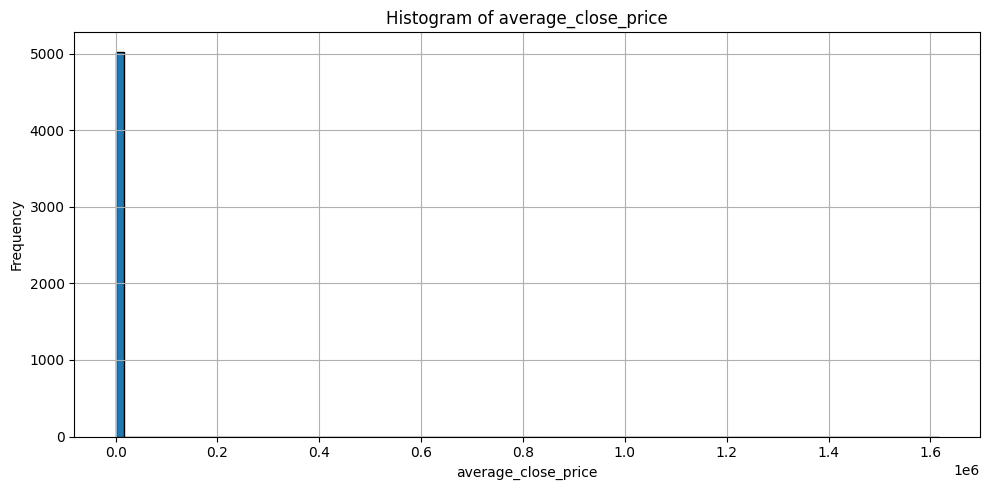

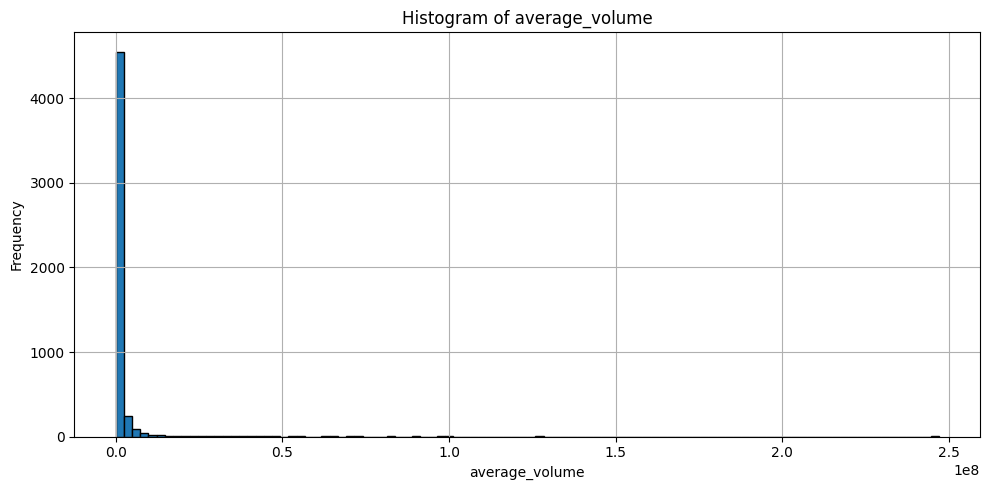

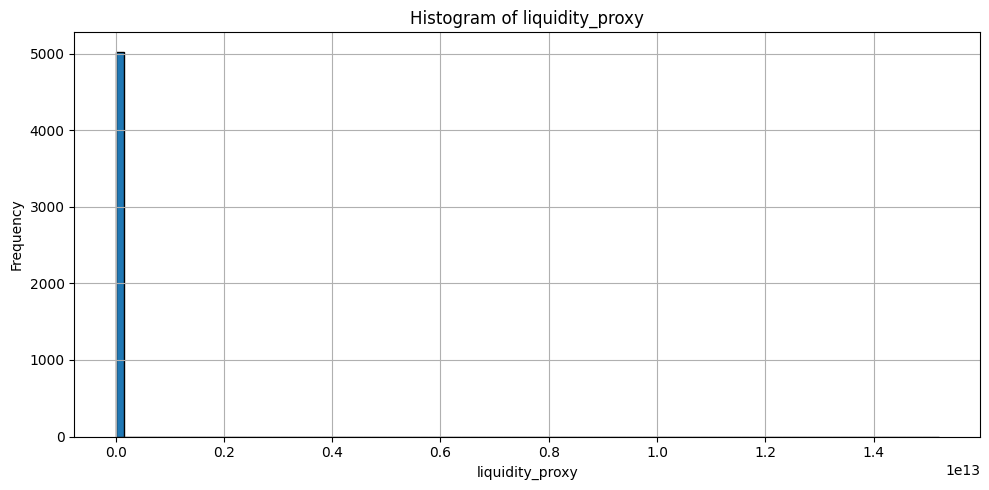

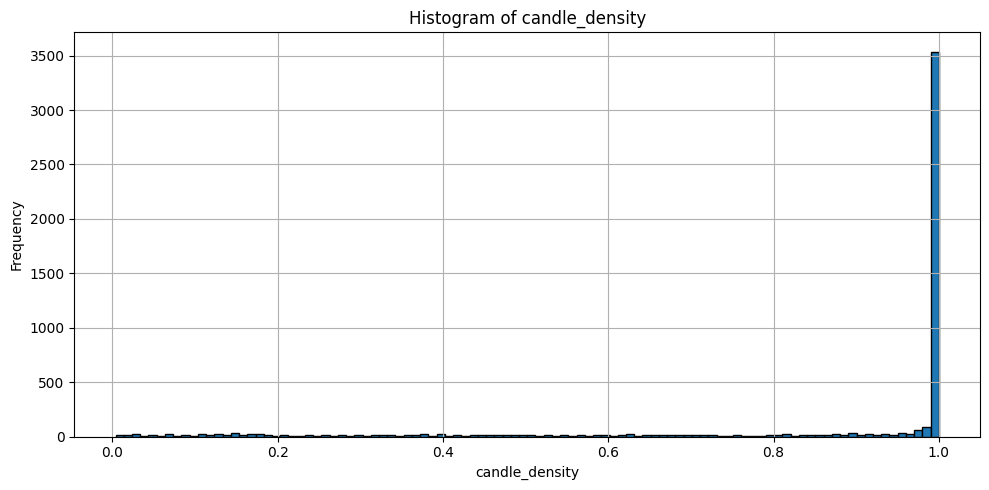

In [22]:
plot_histogram(summary_candles_df, "average_close_price")
plot_histogram(summary_candles_df, "average_volume")
plot_histogram(summary_candles_df, "liquidity_proxy")
plot_histogram(summary_candles_df, "candle_density")

Filters `summary_candles_df` to include only tickers with `metrics` obeying `metrics_thresholds`, removes duplicates, and converts the result to a list.

In [23]:
candle_density_threshold = 0.5
average_close_price_threshold = 1_000
average_volume_threshold = 100_000
liquidity_proxy_threshold = 2_500_000

filtered_summary_candles_df = summary_candles_df[
    (summary_candles_df["candle_density"] >= candle_density_threshold) &
    (summary_candles_df["average_close_price"] < average_close_price_threshold) &
    (summary_candles_df["average_volume"] > average_volume_threshold) &
    (summary_candles_df["liquidity_proxy"] > liquidity_proxy_threshold)
].reset_index(drop=True)

tickers_to_test_schwab = filtered_summary_candles_df["ticker"].drop_duplicates().tolist()

display(filtered_summary_candles_df.sort_values("liquidity_proxy", ascending=False))
print(len(tickers_to_test_schwab), "tickers to test")
display(tickers_to_test_schwab)

ticker exchange  candle_count first_candle last_candle  average_close_price   average_volume     liquidity_proxy  candle_density  total_hours  total_days  total_weeks
1141   NVDA   NASDAQ           249   2024-08-19  2025-08-15             134.4063 246,907,733.3936 33,185,951,217.9067          1.0000   8,664.0000    361.0000      51.5714
1637   TSLA   NASDAQ           249   2024-08-19  2025-08-15             307.7263  98,944,023.4418 30,447,674,783.7679          1.0000   8,664.0000    361.0000      51.5714
1331    QQQ   NASDAQ           249   2024-08-19  2025-08-15             508.0766  39,437,530.6466 20,037,285,944.8090          1.0000   8,664.0000    361.0000      51.5714
5      AAPL   NASDAQ           249   2024-08-19  2025-08-15             222.1857  53,909,867.7510 11,978,001,854.7181          1.0000   8,664.0000    361.0000      51.5714
1063   MSFT   NASDAQ           249   2024-08-19  2025-08-15             434.5842  21,381,344.0442  9,291,994,657.0125          1.0000   8,664.0000    361.0000      51.5714
...     ...      ...           ...          ...         ...                  ...              ...                 ...             ...          ...         ...          ...
1716    VFS   NASDAQ           249   2024-08-19  2025-08-15               3.7030     681,980.3133      2,525,381.3166          1.0000   8,664.0000    361.0000      51.5714
994    MAZE   NASDAQ           136   2025-01-31  2025-08-15              11.9799     210,782.1029      2,525,154.0946          0.5462   4,704.0000    196.0000      28.0000
545    ESOA   NASDAQ           249   2024-08-19  2025-08-15              10.9034     231,251.6948      2,521,428.2429          1.0000   8,664.0000    361.0000      51.5714
166    ATPC   NASDAQ           249   2024-08-19  2025-08-15               1.5154   1,662,848.6104      2,519,926.8632          1.0000   8,664.0000    361.0000      51.5714
1517   SPWH   NASDAQ           249   2024-08-19  2025-08-15               2.3669   1,056,927.3253      2,501,629.8256          1.0000   8,664.0000    361.0000      51.5714

[1851 rows x 12 columns]

1851 tickers to test


['AAL',
 'AAOI',
 'AAON',
 'AAPB',
 'AAPD',
 'AAPL',
 'AAPU',
 'AAXJ',
 'ABAT',
 'ABCL',
 'ABEO',
 'ABL',
 'ABNB',
 'ABP',
 'ABSI',
 'ABUS',
 'ABVE',
 'ABVX',
 'ACAD',
 'ACB',
 'ACDC',
 'ACGL',
 'ACHC',
 'ACIW',
 'ACLS',
 'ACLX',
 'ACMR',
 'ACT',
 'ACWI',
 'ACWX',
 'ADAP',
 'ADBE',
 'ADD',
 'ADEA',
 'ADI',
 'ADMA',
 'ADP',
 'ADPT',
 'ADSK',
 'ADTN',
 'ADTX',
 'ADUS',
 'AEHL',
 'AEHR',
 'AEIS',
 'AEP',
 'AEVA',
 'AEYE',
 'AFRM',
 'AGEN',
 'AGFY',
 'AGIO',
 'AGMH',
 'AGNC',
 'AGRI',
 'AGYS',
 'AHCO',
 'AIFF',
 'AIOT',
 'AIP',
 'AIPI',
 'AIQ',
 'AIRE',
 'AIRR',
 'AISP',
 'AKAM',
 'AKBA',
 'AKRO',
 'ALAB',
 'ALDX',
 'ALGM',
 'ALGN',
 'ALGS',
 'ALGT',
 'ALHC',
 'ALKS',
 'ALKT',
 'ALLO',
 'ALLT',
 'ALMS',
 'ALNT',
 'ALNY',
 'ALRM',
 'ALT',
 'ALTS',
 'ALZN',
 'AMAL',
 'AMAT',
 'AMBA',
 'AMCX',
 'AMD',
 'AMDD',
 'AMDL',
 'AMGN',
 'AMIX',
 'AMKR',
 'AMLX',
 'AMOD',
 'AMPG',
 'AMPH',
 'AMPL',
 'AMRK',
 'AMRX',
 'AMSC',
 'AMSF',
 'AMUU',
 'AMWD',
 'AMZD',
 'AMZN',
 'AMZU',
 'AMZZ',
 'ANAB',
 'AND

### <h3 style="color:yellow;">Getting data from GBQ</h3>

Configuration and Directory Setup

Defines key flags controlling the behavior of the script, such as whether to rebuild results, use local or remote data, and how many tickers to analyze. It also sets up directory paths for saving data, and ensures the necessary folders exist before proceeding.


In [24]:
# Config Flags
get_ticker_list_from_gbq = True
use_local_data_gbq = False
build_results_gbq = True
fresh_start_gbq = True
num_to_test_gbq = 1 #schwab_ticker_num - 1  # If <0, use all
output_stub_gbq = "20240101_"

In [25]:
# Path setup
DATA_DIR = Path("strategies/swing-trading/data")
WALK_FORWARD_DIR_SCHWAB = DATA_DIR / "walk-forward-schwab"                              ### Consider adding later (or sooner and do the data dirs at the same time) !!!
WALK_FORWARD_DIR_GBQ = DATA_DIR / "walk-forward-gbq"
MINUTE_TICKERS_FILE = DATA_DIR / "tickers_random_index_list.txt"

# Delete the entire DATA_DIR folder and all its contents
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)
    print(f"Deleted: {DATA_DIR}")
else:
    print(f"Directory does not exist: {DATA_DIR}")

DATA_DIR.mkdir(parents=True, exist_ok=True)
WALK_FORWARD_DIR_SCHWAB.mkdir(parents=True, exist_ok=True)
WALK_FORWARD_DIR_GBQ.mkdir(parents=True, exist_ok=True)

#MARKER# Make data storage directories here and move this block upstream

Deleted: strategies\swing-trading\data


Load Ticker List

Retrieves the list of tickers to analyze. If `get_ticker_list_from_gbq` is `True`, it queries BigQuery for tickers used in a recent backtesting window and adds a randomized index for sampling. Otherwise, it loads the list from a previously saved local file.


In [26]:
# Pull tickers from DB or local file
if get_ticker_list_from_gbq:
    # You'll need to implement this function to return a DataFrame
    sql = '''
        SELECT DISTINCT ticker 
        FROM main.tf_stocks_for_backtesting("2023-08-01","2024-01-01")
    '''
    all_tickers_gbq = run_sql_query(sql, project_id=gbq_proj_id, credentials_path=private_key) # placeholder
    all_tickers_gbq["random_index"] = random.sample(range(len(all_tickers_gbq)), len(all_tickers_gbq))
    all_tickers_gbq.to_csv(MINUTE_TICKERS_FILE, sep="\t", index=False)
else:
    all_tickers_gbq = pd.read_csv(MINUTE_TICKERS_FILE, sep="\t")

In [27]:
display(all_tickers_gbq)

ticker  random_index
0      GLBZ          2614
1      TIPT          1055
2      IGIC          3340
3      ESCA          4438
4      QCRH          2798
...     ...           ...
4482    TBI          2627
4483    DNB           951
4484     MP          3829
4485     DQ           750
4486   TARO          3714

[4487 rows x 2 columns]

Filter Tickers to Test

Determines which tickers to include in the analysis. If `num_to_test` is greater than 0, it selects only those tickers with a `random_index` below the threshold. Otherwise, it includes all available tickers.

In [28]:
# Filter tickers
if num_to_test_gbq > 0:
    tickers_to_test_gbq = all_tickers_gbq[all_tickers_gbq["random_index"] <= num_to_test_gbq]["ticker"].tolist() + big_ticker_list
else:
    tickers_to_test_gbq = all_tickers_gbq["ticker"].tolist()

In [29]:
display(tickers_to_test_gbq)

['SSSS', 'SUNL', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

In [30]:
def get_most_recent_trading_day(current_date=None):
    """
    Returns the most recent valid NYSE trading day before (or on) the given date.

    This function checks the NYSE trading calendar for the last 30 days leading up to 
    `current_date` (or today, if not specified), and iterates backward to find the most 
    recent trading day. It accounts for weekends and market holidays.

    Args:
        current_date (datetime.date, optional): The reference date. Defaults to today.

    Returns:
        datetime.date: The most recent valid trading day prior to `current_date`.

    Raises:
        ValueError: If no trading day is found within the past 20 calendar days.
    """
    if current_date is None:                                                                 # Use today's date if none is provided
        current_date = date.today()                                                          # Set current_date to today

    nyse = mcal.get_calendar('NYSE')                                                         # Load NYSE trading calendar
    schedule = nyse.valid_days(start_date=(current_date - timedelta(days=30)).isoformat(),   # Get list of valid trading days
                               end_date=current_date.isoformat())                             # within the past 30 days
    valid_days = [d.date() for d in schedule]                                                 # Convert schedule to list of date objects

    for i in range(1, 21):                                                                    # Check the last 20 calendar days
        candidate = current_date - timedelta(days=i)                                          # Go back one day at a time
        if candidate in valid_days:                                                           # Return if the day is a valid trading day
            return candidate                                                                  # Return most recent valid trading day
    raise ValueError("Could not find recent trading day.")  

Set up walkforward analysis parameters for GBQ data, defining the number of periods, analysis/evaluation window lengths, and overall date range. It also handles fresh vs. resumed runs by optionally deleting existing result files and filtering tickers accordingly.


In [31]:
# fresh_start logic
if build_results_gbq:
    overall_finish_gbq = datetime.strptime('2024-03-15', '%Y-%m-%d') #get_most_recent_trading_day()
    print("GBQ Overall finish date:", overall_finish_gbq)

    num_periods_gbq = 3
    print("GBQ Number of periods:", num_periods_gbq)

    analysis_period_gbq = timedelta(days=6*7)
    print("GBQ Analysis period:", analysis_period_gbq)

    evaluation_period_gbq = timedelta(days=4*7)
    print("GBQ Evaluation period:", evaluation_period_gbq)

    end_of_last_analysis_period_gbq = overall_finish_gbq - evaluation_period_gbq
    print("GBQ End of last analysis period:", end_of_last_analysis_period_gbq)

    overall_start_gbq = end_of_last_analysis_period_gbq - num_periods_gbq * analysis_period_gbq
    print("GBQ Overall start date:", overall_start_gbq)
    
    expected_min_analysis_days_gbq = 6 * 4
    print("GBQ Expected min analysis days:", expected_min_analysis_days_gbq)

    if fresh_start_gbq:                                                                 # If a full reset is requested...
        for file in WALK_FORWARD_DIR_GBQ.glob("*"):                                    # Iterate over all files in the walk-forward directory
            file.unlink()                                                          # Delete each file (clears previous results)
    else:                                                                          # Otherwise, resume from where you left off
        existing_files = [f.stem.replace(output_stub_gbq, "")                          # Get list of tickers that already have result files
                        for f in WALK_FORWARD_DIR_GBQ.glob("*.txt")]                   # Only look for .txt files matching previous outputs
        tickers_to_test_gbq = [t for t in tickers_to_test_gbq if t not in existing_files]  # Remove tickers that already have results from the test list

#MARKER# Transfer this to Schwab like logic

GBQ Overall finish date: 2024-03-15 00:00:00
GBQ Number of periods: 3
GBQ Analysis period: 42 days, 0:00:00
GBQ Evaluation period: 28 days, 0:00:00
GBQ End of last analysis period: 2024-02-16 00:00:00
GBQ Overall start date: 2023-10-13 00:00:00
GBQ Expected min analysis days: 24


Fetch daily data for each ticker from GBQ.

In [32]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

candles_dict_gbq = {}
num_tickers = len(tickers_to_test_gbq)

for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    print(f"({i}/{num_tickers}) Fetching data for {ticker}")
    candles_dict_gbq[ticker] = get_ticker_data(
        ticker,
        overall_start_gbq,
        local=use_local_data_gbq,
        credentials_path=private_key,
        project_id=gbq_proj_id
    )

2025-08-18 15:52:43
(1/7) Fetching data for SSSS
(2/7) Fetching data for SUNL
(3/7) Fetching data for AAPL
(4/7) Fetching data for MSFT
(5/7) Fetching data for GOOGL
(6/7) Fetching data for AMZN
(7/7) Fetching data for TSLA


In [33]:
display(candles_dict_gbq)

{'SSSS':     ticker   date_time   open   high    low  close       volume
 0     SSSS  2023-10-16 4.1000 4.1400 4.0000 4.1200  78,084.0000
 1     SSSS  2023-10-17 4.1000 4.1700 4.1000 4.1600  50,170.0000
 2     SSSS  2023-10-18 4.1100 4.1400 4.1000 4.1200  29,252.0000
 3     SSSS  2023-10-19 4.1000 4.1700 4.1000 4.1500  62,245.0000
 4     SSSS  2023-10-20 4.1700 4.1800 4.0700 4.1800  93,317.0000
 ..     ...         ...    ...    ...    ...    ...          ...
 100   SSSS  2024-03-11 4.3400 4.3912 4.3400 4.3420  49,720.0000
 101   SSSS  2024-03-12 4.3500 4.3700 4.3400 4.3500  43,257.0000
 102   SSSS  2024-03-13 4.3300 4.3900 4.3300 4.3600  67,467.0000
 103   SSSS  2024-03-14 4.2400 4.3700 4.2400 4.3400 121,075.0000
 104   SSSS  2024-03-15 4.3300 4.3600 4.3000 4.3600 112,934.0000
 
 [105 rows x 7 columns],
 'SUNL':    ticker   date_time   open   high    low  close      volume
 0    SUNL  2023-10-16 0.5350 0.5400 0.4401 0.4401  4,991.0000
 1    SUNL  2023-10-17 0.4550 0.4550 0.4550 0.4550 

### <h3 style="color:yellow;">Save Schwab and GBQ data to disk</h3>

In [34]:
def save_ticker_data(data_dict, end_path_component):
    """
    Saves each DataFrame in a dictionary to a separate tab-delimited .txt file under a specified subdirectory.

    Args:
        data_dict (dict): Dictionary where keys are ticker symbols and values are pandas DataFrames.
        end_path_component (str): Subfolder name under DATA_DIR where files will be saved.

    Returns:
        None. Files are saved to disk, and progress is printed to the console.
    """
    DAILY_TICKER_DATA_DIR = DATA_DIR / end_path_component
    DAILY_TICKER_DATA_DIR.mkdir(parents=True, exist_ok=True)

    num_tickers = len(data_dict)
    for i, (ticker, df) in enumerate(data_dict.items(), start=1):
        if not isinstance(df, pd.DataFrame) or df.empty:
            print(f"({i}/{num_tickers}) Skipping {ticker} — no data available")
            continue

        output_file = DAILY_TICKER_DATA_DIR / f"{ticker}.txt"
        try:
            df.to_csv(output_file, sep="\t", index=False)
            print(f"({i}/{num_tickers}) Saved {ticker} data to {output_file}")
        except Exception as e:
            print(f"({i}/{num_tickers}) Failed to save {ticker}: {e}")

Save both Schwab and GBQ data to their respective folders.

In [35]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
save_ticker_data(candles_dict_gbq, "local-ticker-data-gbq")

2025-08-18 15:52:53
(1/7) Saved SSSS data to strategies\swing-trading\data\local-ticker-data-gbq\SSSS.txt
(2/7) Saved SUNL data to strategies\swing-trading\data\local-ticker-data-gbq\SUNL.txt
(3/7) Saved AAPL data to strategies\swing-trading\data\local-ticker-data-gbq\AAPL.txt
(4/7) Saved MSFT data to strategies\swing-trading\data\local-ticker-data-gbq\MSFT.txt
(5/7) Saved GOOGL data to strategies\swing-trading\data\local-ticker-data-gbq\GOOGL.txt
(6/7) Saved AMZN data to strategies\swing-trading\data\local-ticker-data-gbq\AMZN.txt
(7/7) Saved TSLA data to strategies\swing-trading\data\local-ticker-data-gbq\TSLA.txt


In [36]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
save_ticker_data(candles_dict_schwab, "local-ticker-data-schwab")

2025-08-18 15:52:53
(1/5029) Saved AACB data to strategies\swing-trading\data\local-ticker-data-schwab\AACB.txt
(2/5029) Saved AACBR data to strategies\swing-trading\data\local-ticker-data-schwab\AACBR.txt
(3/5029) Saved AACBU data to strategies\swing-trading\data\local-ticker-data-schwab\AACBU.txt
(4/5029) Saved AACG data to strategies\swing-trading\data\local-ticker-data-schwab\AACG.txt
(5/5029) Saved AACI data to strategies\swing-trading\data\local-ticker-data-schwab\AACI.txt
(6/5029) Saved AACIU data to strategies\swing-trading\data\local-ticker-data-schwab\AACIU.txt
(7/5029) Saved AACIW data to strategies\swing-trading\data\local-ticker-data-schwab\AACIW.txt
(8/5029) Saved AADR data to strategies\swing-trading\data\local-ticker-data-schwab\AADR.txt
(9/5029) Saved AAL data to strategies\swing-trading\data\local-ticker-data-schwab\AAL.txt
(10/5029) Saved AALG data to strategies\swing-trading\data\local-ticker-data-schwab\AALG.txt
(11/5029) Saved AAME data to strategies\swing-trading

## <h2 style="color:purple;">Begin Back-Testing</h2>

### <h3 style="color:yellow;">Running analysis on Schwab data</h3>

Set configuration flags for Schwab data sourcing, result building, and output naming.

In [37]:
# Config Flags
get_ticker_list_from_schwab = False
use_local_data_schwab = True
build_results_schwab = True
fresh_start_schwab = True
output_stub_schwab = pd.to_datetime(summary_candles_df["last_candle"].max()).strftime("%Y%m%d_")

Calculating some time metrics for use in subsequent calculations.

In [38]:
display(summary_candles_df.sort_values("liquidity_proxy", ascending=False)[["ticker", "total_hours", "total_days", "total_weeks"]][0:1])
max_weeks = summary_candles_df.sort_values("liquidity_proxy", ascending=False).iloc[0]["total_weeks"]
max_days = summary_candles_df.sort_values("liquidity_proxy", ascending=False).iloc[0]["total_days"]
max_hours = summary_candles_df.sort_values("liquidity_proxy", ascending=False).iloc[0]["total_hours"]

display(max_weeks)

ticker  total_hours  total_days  total_weeks
559   BINI   8,664.0000    361.0000      51.5714

51.57142857142857

Define walk-forward analysis period ranges and manage existing Schwab result files based on the `fresh_start_schwab` flag.

In [39]:
# fresh_start logic weeks/older
if build_results_schwab:    

    overall_finish_schwab              = pd.to_datetime(summary_candles_df["last_candle"].max())         # Most recent timestamp available in the dataset

    num_periods_schwab                 = 1                                                                # Number of walk-forward cycles to simulate
    cycle_length_weeks_schwab         = round(max_weeks / num_periods_schwab, ndigits=0)                                   # Total weeks per analysis + evaluation cycle
    cycle_length_days_schwab          = round(max_days / num_periods_schwab, ndigits=0)                                    # Total days per analysis + evaluation cycle
    analysis_ratio_schwab             = 1                                                              # Portion of each cycle allocated to analysis
    evaluation_ratio_schwab           = 1 - analysis_ratio_schwab                                        # Remaining portion allocated to evaluation

    analysis_weeks_schwab             = cycle_length_weeks_schwab * analysis_ratio_schwab               # Total weeks in each analysis window
    evaluation_weeks_schwab           = cycle_length_weeks_schwab * evaluation_ratio_schwab             # Total weeks in each evaluation window

    days_in_week_schwab               = 7                                                                # Used to convert weeks to days
    analysis_period_schwab            = timedelta(days=analysis_weeks_schwab*days_in_week_schwab)     # Total duration of an analysis window, expressed in days
    evaluation_period_schwab          = timedelta(days=evaluation_weeks_schwab*days_in_week_schwab)   # Total duration of an evaluation window, expressed in days
    
    end_of_last_analysis_period_schwab = overall_finish_schwab - evaluation_period_schwab                   # End date of final analysis window
    overall_start_schwab = end_of_last_analysis_period_schwab - num_periods_schwab * analysis_period_schwab  # Earliest date included in analysis
    expected_min_analysis_days_schwab = 1 #(analysis_weeks_schwab + evaluation_weeks_schwab)*days_in_week_schwab           # Heuristic: expected number of days required for a valid analysis

    if fresh_start_schwab:                                                                              # If a full reset is requested...
        for file in WALK_FORWARD_DIR_SCHWAB.glob("*"):                                                  # Iterate over all files in the walk-forward directory
            file.unlink()                                                                                # Delete each file (clears previous results)
    else:                                                                                                 # Otherwise, resume from where you left off
        existing_files = [f.stem.replace(output_stub_schwab, "")                                          # Get list of tickers that already have result files
                        for f in WALK_FORWARD_DIR_SCHWAB.glob("*.txt")]                                   # Only look for .txt files matching previous outputs
        tickers_to_test_schwab = [t for t in tickers_to_test_schwab if t not in existing_files]           # Remove tickers that already have results from the test list

    print("SCHWAB Overall finish date:", overall_finish_schwab)
    print("SCHWAB Number of periods:", num_periods_schwab)
    print("SCHWAB Analysis plus evaluation total weeks:", cycle_length_weeks_schwab)
    print("SCHWAB Analysis ratio:", analysis_ratio_schwab)
    print("SCHWAB Evaluation ratio:", evaluation_ratio_schwab)
    print("SCHWAB Analysis weeks:", analysis_weeks_schwab)
    print("SCHWAB Evaluation weeks:", evaluation_weeks_schwab)
    print("SCHWAB Analysis period:", analysis_period_schwab)
    print("SCHWAB Evaluation period:", evaluation_period_schwab)
    print("SCHWAB End of last analysis period:", end_of_last_analysis_period_schwab)
    print("SCHWAB Overall start date:", overall_start_schwab)
    print("SCHWAB Expected min analysis days:", expected_min_analysis_days_schwab)

#MARKER# Using this logic

SCHWAB Overall finish date: 2025-08-15 00:00:00
SCHWAB Number of periods: 1
SCHWAB Analysis plus evaluation total weeks: 52.0
SCHWAB Analysis ratio: 1
SCHWAB Evaluation ratio: 0
SCHWAB Analysis weeks: 52.0
SCHWAB Evaluation weeks: 0.0
SCHWAB Analysis period: 364 days, 0:00:00
SCHWAB Evaluation period: 0:00:00
SCHWAB End of last analysis period: 2025-08-15 00:00:00
SCHWAB Overall start date: 2024-08-16 00:00:00
SCHWAB Expected min analysis days: 1


In [40]:
def prepare_analysis_structure(ticker, end_of_last_analysis_period, analysis_period, evaluation_period, num_periods):
    """
    Constructs a DataFrame defining rolling analysis and evaluation periods for a given ticker.

    Args:
        ticker (str): Ticker symbol to assign to the generated rows.
        end_of_last_analysis_period (datetime): The most recent analysis period end date.
        analysis_period (timedelta): Duration of each analysis period.
        evaluation_period (timedelta): Duration of each evaluation period following the analysis.
        num_periods (int): Number of rolling periods to generate.

    Returns:
        pd.DataFrame: A DataFrame with `num_periods` rows and the columns at the end of the function:
    """
    analysis_period_starts = [                                                                  # Generate list of period start dates
        end_of_last_analysis_period - (analysis_period + evaluation_period) * i                 # Each start is offset by i * total cycle length
        for i in range(1, num_periods + 1)                                                      # For the last `num_periods` analysis windows
    ]

    df = pd.DataFrame({                                                                         # Create base DataFrame for the analysis structure
        "ticker": ticker,                                                                       # Set the ticker label
        "analysis_period_start": pd.to_datetime(analysis_period_starts),                        # Assign start dates for each analysis period
    })

    df["analysis_period_end"] = df["analysis_period_start"] + analysis_period                   # Calculate the end of each analysis period
    df["analysis_buy"] = 0.0                                                                    # Initialize buy threshold column
    df["analysis_sell"] = 0.0                                                                   # Initialize sell threshold column
    df["analysis_return"] = 0.0                                                                 # Initialize return column for analysis period
    df["analysis_trades"] = 0                                                                   # Initialize number of trades in analysis period
    df["analysis_eval_metric"] = 0.0                                                            # Initialize penalized evaluation metric column
    df["evaluation_period_start"] = df["analysis_period_end"] + timedelta(days=1)               # Evaluation starts the day after analysis ends
    df["evaluation_period_end"] = df["evaluation_period_start"] + evaluation_period             # Evaluation end is offset from its start
    df["evaluation_return"] = 0.0                                                               # Initialize evaluation return column
    df["evaluation_trades"] = 0                                                                 # Initialize evaluation trade count
    df["evaluation_data_good"] = False                                                          # Flag whether evaluation data exists

    return df                                                                                   # Return the prepared DataFrame

Builds the base results structure for each Schwab ticker by generating rolling analysis and evaluation windows using `prepare_analysis_structure()`.

In [41]:
# 1. Build the base results structure
results_structure_dict_schwab = {}
num_tickers_schwab = len(tickers_to_test_schwab)

# Prepare the analysis structure for each ticker
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    print(f"({i}/{num_tickers_schwab}) Preparing analysis structure for {ticker}")
    results_structure_dict_schwab[ticker] = prepare_analysis_structure(
        ticker,
        end_of_last_analysis_period_schwab,
        analysis_period_schwab,
        evaluation_period_schwab,
        num_periods_schwab
    )

(1/1851) Preparing analysis structure for AAL
(2/1851) Preparing analysis structure for AAOI
(3/1851) Preparing analysis structure for AAON
(4/1851) Preparing analysis structure for AAPB
(5/1851) Preparing analysis structure for AAPD
(6/1851) Preparing analysis structure for AAPL
(7/1851) Preparing analysis structure for AAPU
(8/1851) Preparing analysis structure for AAXJ
(9/1851) Preparing analysis structure for ABAT
(10/1851) Preparing analysis structure for ABCL
(11/1851) Preparing analysis structure for ABEO
(12/1851) Preparing analysis structure for ABL
(13/1851) Preparing analysis structure for ABNB
(14/1851) Preparing analysis structure for ABP
(15/1851) Preparing analysis structure for ABSI
(16/1851) Preparing analysis structure for ABUS
(17/1851) Preparing analysis structure for ABVE
(18/1851) Preparing analysis structure for ABVX
(19/1851) Preparing analysis structure for ACAD
(20/1851) Preparing analysis structure for ACB
(21/1851) Preparing analysis structure for ACDC
(22/1

In [42]:
display(results_structure_dict_schwab)

{'AAL':   ticker analysis_period_start analysis_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric evaluation_period_start evaluation_period_end  evaluation_return  evaluation_trades  evaluation_data_good
 0    AAL            2024-08-16          2025-08-15        0.0000         0.0000           0.0000                0                0.0000              2025-08-16            2025-08-16             0.0000                  0                 False,
 'AAOI':   ticker analysis_period_start analysis_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric evaluation_period_start evaluation_period_end  evaluation_return  evaluation_trades  evaluation_data_good
 0   AAOI            2024-08-16          2025-08-15        0.0000         0.0000           0.0000                0                0.0000              2025-08-16            2025-08-16             0.0000                  0                 False,
 'AAON':   

In [43]:
def get_trades(data, upper_bound, lower_bound, time_start):
    """
    Simulates a basic swing trading strategy using high/low breakouts.

    Iterates over a DataFrame of daily OHLC data to identify buy and sell trades:
    - A **buy** occurs when the low of the day falls below or equals the `lower_bound`.
    - A **sell** occurs when the high of the day rises above or equals the `upper_bound`.
    - Only one position can be held at a time.
    - If the end of the data is reached while a position is open, it is force-closed 
      at the midpoint of the final day's high and low.

    Args:
        data (pd.DataFrame): Daily OHLC data with columns ['date_time', 'high', 'low'].
        upper_bound (float): The price level that triggers a sell.
        lower_bound (float): The price level that triggers a buy.
        time_start (datetime-like): Trades are only evaluated for rows on or after this timestamp.

    Returns:
        pd.DataFrame: A DataFrame of executed trades with columns:
            ['date', 'type', 'daily_high', 'daily_low', 'trade_price']
    """
    time_start = pd.to_datetime(time_start)  # Ensure compatible type for comparison
    data = data.copy()
    data["date_time"] = pd.to_datetime(data["date_time"])    
    state = 0                                                                                     # 0 = not in position, 1 = in position
    trades = []                                                                                   # List to store executed trades

    for i, row in data.iterrows():                                                                # Iterate over each row in the data
        if row["date_time"] < time_start:                                                         # Skip rows before the time_start threshold
            continue                                                                              # Move to the next row

        if state == 0 and row["low"] <= lower_bound:                                              # Entry condition: not in position and price hits or drops below lower bound
            trades.append({                                                                       # Record a buy trade
                "date": row["date_time"],                                                         # Trade date
                "type": "buy",                                                                    # Trade type
                "daily_high": row["high"],                                                        # High of the day
                "daily_low": row["low"],                                                          # Low of the day
                "trade_price": lower_bound                                                        # Executed price at lower bound
            })
            state = 1                                                                             # Update state to indicate we are now in a position
        elif state == 1 and row["high"] >= upper_bound:                                           # Exit condition: in position and price rises above upper bound
            trades.append({                                                                       # Record a sell trade
                "date": row["date_time"],                                                         # Trade date
                "type": "sell",                                                                   # Trade type
                "daily_high": row["high"],                                                        # High of the day
                "daily_low": row["low"],                                                          # Low of the day
                "trade_price": upper_bound                                                        # Executed price at upper bound
            })
            state = 0                                                                             # Update state to indicate we're out of position

    if state == 1:                                                                                # If still in position at the end, force close
        last = data.iloc[-1]                                                                      # Get the last row in the data
        trades.append({                                                                           # Record a forced sell trade
            "date": last["date_time"],                                                            # Trade date
            "type": "sell",                                                                       # Trade type
            "daily_high": last["high"],                                                           # High of the day
            "daily_low": last["low"],                                                             # Low of the day
            "trade_price": 0.5 * (last["high"] + last["low"])                                     # Forced close price is midpoint between high and low
        })

    return pd.DataFrame(trades)                                                                   # Convert list of trades to a DataFrame and return

def get_returns(data, upper_bound, lower_bound, time_start, starting_cash=10000):
    """
    Simulates a swing trading strategy and calculates the annualized return.

    Executes trades based on breakout conditions using `get_trades()`:
    - Buys when price hits `lower_bound`
    - Sells when price hits `upper_bound`
    - Assumes full portfolio allocation on each trade (no partial positions)
    - Closes the final position at the end of the data if still open

    Computes:
    - The total number of buy-side trades
    - The annualized return over the trading period

    Args:
        data (pd.DataFrame): Daily OHLC data with columns ['date_time', 'high', 'low'].
        upper_bound (float): Price level that triggers a sell.
        lower_bound (float): Price level that triggers a buy.
        time_start (datetime-like): The start date for evaluating trades.
        starting_cash (float): Initial portfolio cash. Defaults to 10,000.

    Returns:
        dict: {
            "annualized_return" (float or None): Annualized percentage return,
                or None if no trades were executed or time span is 0.
            "num_trades" (int): Number of completed buy trades.
        }
    """
    trades = get_trades(data, upper_bound, lower_bound, time_start)                             # Run the trade simulation using breakout rules

    if trades.empty:                                                                            # If no trades occurred, return early
        return {"annualized_return": None, "num_trades": 0}                                     # Return None and 0 trades if no signals

    shares = 0                                                                                  # Initialize position size
    cash = starting_cash                                                                        # Start with the full cash amount

    for _, trade in trades.iterrows():                                                          # Loop through the trades chronologically
        if trade["type"] == "buy":                                                              # If it's a buy trade
            shares = cash / trade["trade_price"]                                                # Allocate entire portfolio into shares
            cash = 0                                                                            # Cash is now fully deployed
        elif trade["type"] == "sell":                                                           # If it's a sell trade
            cash = shares * trade["trade_price"]                                                # Liquidate shares to get cash
            shares = 0                                                                          # No position remains

    last_day = pd.to_datetime(data["date_time"].max())  
    time_start = pd.to_datetime(time_start)                                                          # Last available date in the data
    period_years = (last_day - time_start).days / 365.25                        # Duration of trading period in years

    if period_years == 0:                                                                       # Edge case: zero duration (e.g., same-day trades)
        return {"annualized_return": None, "num_trades": trades['type'].eq("buy").sum()}        # Avoid divide-by-zero; return None safely

    total_return = cash / starting_cash - 1                                                     # Compute simple return (final / initial - 1)
    annualized = (cash / starting_cash) ** (1 / period_years) - 1                               # Convert total return to annualized return

    return {"total_return": total_return, "annualized_return": annualized, "num_trades": trades['type'].eq("buy").sum()}      # Return final results as a dictionary

def analyze_ticker_data(data, grid_size=20, num_pse=1.5):
    """
    Performs a grid search to optimize buy and sell thresholds for a swing trading strategy.

    This function evaluates a range of lower-bound (buy) and upper-bound (sell) thresholds
    to determine which combination yields the best penalized return, where penalization is
    based on the pseudo-standard error of the return.

    The performance of each threshold pair is evaluated using:
        - Annualized return
        - Number of trades
        - Pseudo-standard error: |return| / sqrt(trades)
        - Penalized return: return - (num_pse * pseudo_se)

    Args:
        data (pd.DataFrame): Historical OHLC data with at least 'low', 'high', and 'date_time' columns.
        grid_size (int): Number of evenly spaced values to test for both lb and ub thresholds.
        num_pse (float): Penalty multiplier applied to the pseudo-standard error.

    Returns:
        pd.DataFrame: A single-row DataFrame containing the best-performing parameters:
            - lb (float): Optimal lower bound (buy threshold)
            - ub (float): Optimal upper bound (sell threshold)
            - spread (float): ub - lb
            - return (float): Annualized return for that configuration
            - trades (int): Number of buy trades
            - pseudo_se (float): Pseudo-standard error of the return
            - return_lb (float): Penalized return used for selection
            - time_start (datetime): Start time of the evaluation period

    Raises:
        ValueError: If no valid parameter combinations are found (e.g., no trades or all return_lb are NaN).
    """
    lb_start = data['low'].quantile(0.01)
    lb_end = data['low'].quantile(0.75)
    ub_start = data['high'].quantile(0.10)
    ub_end = data['high'].quantile(0.99)
    time_start = data['date_time'].min()

    lb_values = np.linspace(lb_start, lb_end, grid_size)
    ub_values = np.linspace(ub_start, ub_end, grid_size)

    experiments = []

    for lb in lb_values:
        for ub in ub_values:
            if lb >= ub:
                continue

            result = get_returns(data, upper_bound=ub, lower_bound=lb, time_start=time_start)
            num_trades = result.get("num_trades", 0)

            if num_trades == 0:
                continue  # Skip configurations with no trades

            annualized_return = result.get("annualized_return") or 0.0
            spread = ub - lb
            pseudo_se = abs(annualized_return) / np.sqrt(num_trades)
            return_lb = annualized_return - num_pse * pseudo_se

            experiments.append({
                "lb": lb,
                "ub": ub,
                "spread": spread,
                "return": annualized_return,
                "trades": num_trades,
                "pseudo_se": pseudo_se,
                "return_lb": return_lb,
                "time_start": time_start
            })

    df = pd.DataFrame(experiments)

    if df.empty:
        raise ValueError("No valid parameter combinations found.")

    max_return_lb = df["return_lb"].max()
    best = df[df["return_lb"] == max_return_lb]
    best = best.sort_values(["trades", "spread"], ascending=[False, True]).tail(1)

    return best.reset_index(drop=True)

def run_analysis_loop(ticker_results, daily_data, expected_min_analysis_days):                          # Perform optimization and evaluation for each analysis/evaluation period
    """
    Performs optimization and evaluation for each row in the walk-forward results DataFrame.

    Args:
        ticker_results (pd.DataFrame): Table with period metadata and signal slots for a single ticker.
        daily_data (pd.DataFrame): OHLCV data with a 'date_time' column.
        expected_min_analysis_days (int): Minimum number of days required to consider an analysis window valid.

    Returns:
        pd.DataFrame: Updated ticker_results with optimized thresholds and evaluation performance filled in.
    """
    for idx, row in ticker_results.iterrows():                                                           # Iterate through each row (period) of the ticker results table
        analysis_data = daily_data[                                                                      # Slice the data for the current analysis window
            (daily_data["date_time"] >= row["analysis_period_start"]) &                                  # Include data on or after the analysis start
            (daily_data["date_time"] <= row["analysis_period_end"])                                      # And on or before the analysis end
        ]

        if len(analysis_data) < expected_min_analysis_days:                                              # Skip this window if not enough trading days
            continue

        evaluation_data = daily_data[                                                                    # Slice the data for the evaluation window
            (daily_data["date_time"] >= row["evaluation_period_start"]) &                                # Include data on or after the evaluation start
            (daily_data["date_time"] <= row["evaluation_period_end"])                                    # And on or before the evaluation end
        ]

        if not analysis_data.empty:                                                                       # Proceed if there's valid analysis data
            period_results = analyze_ticker_data(analysis_data)                                           # Run optimization for buy/sell thresholds

            ticker_results.at[idx, "analysis_buy"] = period_results["lb"][0]                              # Save optimized lower bound (buy threshold)
            ticker_results.at[idx, "analysis_sell"] = period_results["ub"][0]                             # Save optimized upper bound (sell threshold)
            ticker_results.at[idx, "analysis_return"] = period_results["return"][0]                       # Save annualized return for this config
            ticker_results.at[idx, "analysis_trades"] = period_results["trades"][0]                       # Save number of trades
            ticker_results.at[idx, "analysis_eval_metric"] = period_results["return_lb"][0]              # Save penalized return metric
        else:
            ticker_results.at[idx, "analysis_return"] = np.nan                                            # If no data, store NaN as placeholder

        if not evaluation_data.empty:                                                                     # Proceed if there's evaluation data
            ticker_results.at[idx, "evaluation_data_good"] = True                                         # Mark the data as usable

            eval_results = get_returns(
                evaluation_data,
                upper_bound=ticker_results.at[idx, "analysis_sell"],
                lower_bound=ticker_results.at[idx, "analysis_buy"],
                time_start=ticker_results.at[idx, "evaluation_period_start"]
            )

            ticker_results.at[idx, "evaluation_trades"] = eval_results["num_trades"]                      # Store number of trades during evaluation
            ticker_results.at[idx, "evaluation_return"] = eval_results["annualized_return"]               # Store annualized return during evaluation

    return ticker_results                                                                                 # Return the updated DataFrame

Runs the walk-forward optimization and evaluation loop for each Schwab ticker and stores the updated results in `final_results_dict_schwab`.

In [ ]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
final_results_dict_schwab = {}
num_tickers_schwab = len(tickers_to_test_schwab)

# 2. Run analysis and evaluation loop
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    print(f"({i}/{num_tickers_schwab}) Running analysis loop for {ticker} from Schwab data")
    final_results_dict_schwab[ticker] = run_analysis_loop(
        results_structure_dict_schwab[ticker],
        candles_dict_schwab[ticker],
        expected_min_analysis_days_schwab
    )

2025-08-18 15:53:17
(1/1851) Running analysis loop for AAL from Schwab data
(2/1851) Running analysis loop for AAOI from Schwab data
(3/1851) Running analysis loop for AAON from Schwab data
(4/1851) Running analysis loop for AAPB from Schwab data
(5/1851) Running analysis loop for AAPD from Schwab data
(6/1851) Running analysis loop for AAPL from Schwab data
(7/1851) Running analysis loop for AAPU from Schwab data
(8/1851) Running analysis loop for AAXJ from Schwab data
(9/1851) Running analysis loop for ABAT from Schwab data
(10/1851) Running analysis loop for ABCL from Schwab data
(11/1851) Running analysis loop for ABEO from Schwab data
(12/1851) Running analysis loop for ABL from Schwab data
(13/1851) Running analysis loop for ABNB from Schwab data
(14/1851) Running analysis loop for ABP from Schwab data
(15/1851) Running analysis loop for ABSI from Schwab data
(16/1851) Running analysis loop for ABUS from Schwab data
(17/1851) Running analysis loop for ABVE from Schwab data
(18/18

Taking a look at `final_results_dict_schwab`.

In [ ]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Example: display the DataFrame at index 0
ticker, df = final_results_list_schwab[0]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)

In [ ]:
def add_analysis_metrics(results_dict, price_data_dict):
    """
    Adds analytics columns to each DataFrame in results_dict using the associated OHLCV data.

    Parameters:
    - results_dict (dict): Maps tickers to DataFrames of walk-forward analysis results.
    - price_data_dict (dict): Maps tickers to their full OHLCV DataFrames with 'date_time', 'high', 'low', 'close'.

    Returns:
    - dict: Updated results_dict with new columns added.
    """
    updated_results = {}

    for ticker, df in results_dict.items():
        prices = price_data_dict[ticker].copy()
        prices["date_time"] = pd.to_datetime(prices["date_time"])
        last_close = prices["close"].iloc[-1]

        df = df.copy()
        df["current_price_below_lb"] = df["analysis_buy"].apply(
            lambda lb: last_close < lb if pd.notnull(lb) else np.nan
        )
        df["percent_below_lb"] = df["analysis_buy"].apply(
            lambda lb: (lb - last_close) / lb if pd.notnull(lb) else np.nan
        )
        df["current_price_below_ub"] = df["analysis_sell"].apply(
            lambda ub: last_close < ub if pd.notnull(ub) else np.nan
        )
        df["percent_below_ub"] = df["analysis_sell"].apply(
            lambda ub: (ub - last_close) / ub if pd.notnull(ub) else np.nan
        )
        df["current_price_between_bounds"] = df.apply(
            lambda row: (
                row["analysis_buy"] < last_close < row["analysis_sell"]
                if pd.notnull(row["analysis_buy"]) and pd.notnull(row["analysis_sell"])
                else np.nan
            ),
            axis=1
        )

        num_days_lb_list = []
        num_days_ub_list = []
        trend_slope_list = []
        norm_trend_slope_list = []

        for _, row in df.iterrows():
            lb = row["analysis_buy"]
            ub = row["analysis_sell"]
            start_date = pd.to_datetime(row["analysis_period_start"])
            end_date = pd.to_datetime(row["analysis_period_end"])

            analysis_period = prices[
                (prices["date_time"] >= start_date) &
                (prices["date_time"] <= end_date)
            ].copy()

            analysis_period = analysis_period.sort_values("date_time", ascending=False)

            # Days below lb
            if pd.notnull(lb):
                count_lb = 0
                for _, candle in analysis_period.iterrows():
                    if candle["high"] < lb and candle["low"] < lb:
                        count_lb += 1
                    else:
                        break
                num_days_lb_list.append(count_lb)
            else:
                num_days_lb_list.append(np.nan)

            # Days below ub
            if pd.notnull(ub):
                count_ub = 0
                for _, candle in analysis_period.iterrows():
                    if candle["high"] < ub and candle["low"] < ub:
                        count_ub += 1
                    else:
                        break
                num_days_ub_list.append(count_ub)
            else:
                num_days_ub_list.append(np.nan)

            # Trend slope (raw and normalized) using real time
            if len(analysis_period) >= 2:
                closes = analysis_period["close"].values
                x = mdates.date2num(analysis_period["date_time"])  # use real time axis
                slope, _, _, _, _ = linregress(x, closes)
                trend_slope_list.append(slope)
                norm_slope = slope / closes.mean() if closes.mean() != 0 else 0
                norm_trend_slope_list.append(norm_slope)
            else:
                trend_slope_list.append(np.nan)
                norm_trend_slope_list.append(np.nan)

        df["num_days_below_lb"] = num_days_lb_list
        df["num_days_below_ub"] = num_days_ub_list
        df["trend_slope"] = trend_slope_list
        df["norm_trend_slope"] = norm_trend_slope_list  # For scoring

        # Cyclicality measure
        full_prices = prices.set_index("date_time")
        full_span = full_prices["high"].max() - full_prices["low"].min()
        avg_day_range = (full_prices["high"] - full_prices["low"]).mean()
        cyclicality_ratio = avg_day_range / full_span if full_span != 0 else np.nan
        df["cyclicality"] = cyclicality_ratio

        updated_results[ticker] = df

    return updated_results


In [ ]:
if num_periods_schwab == 1 and analysis_ratio_schwab == 1:
    final_results_dict_schwab = add_analysis_metrics(final_results_dict_schwab, candles_dict_schwab)
    display(final_results_dict_schwab)

In [ ]:
def score_profit_probability(results_dict, weights=None, bound_reference="lower"):
    """
    Adds a profit probability score, ranking, and swing probability category to each DataFrame in a results dictionary.
    Also records the weight values used into each DataFrame as columns.

    Parameters:
    - results_dict (dict): Dictionary of {ticker: pd.DataFrame} with analysis results.
    - weights (dict, optional): Weights for each scoring component.
    - bound_reference (str): Either "lower" or "upper" to indicate which bound to use for scoring.

    Returns:
    - dict: Updated results_dict with 'profit_score', 'profit_rank', 'swing_probability', and weight columns.
    """
    if bound_reference not in {"lower", "upper"}:
        raise ValueError("bound_reference must be either 'lower' or 'upper'")

    suffix = "lb" if bound_reference == "lower" else "ub"

    if weights is None:
        weights = {
            f"current_price_below_{suffix}": 1.0,
            f"percent_below_{suffix}": 0.0,
            f"num_days_below_{suffix}": 0.0,
            "cyclicality": 0.75,
            "norm_trend_slope": 1.75  # ✅ New metric
        }

    combined_df = pd.concat(results_dict.values(), ignore_index=True)
    combined_df[f"current_price_below_{suffix}"] = combined_df[f"current_price_below_{suffix}"].astype(float)

    # Rank components
    combined_df["_rank_percent"] = combined_df[f"percent_below_{suffix}"].rank(pct=True)
    combined_df["_rank_days"] = combined_df[f"num_days_below_{suffix}"].rank(pct=True)
    combined_df["_rank_cyclicality"] = combined_df["cyclicality"].rank(pct=True)
    combined_df["_rank_trend"] = combined_df["norm_trend_slope"].rank(pct=True)

    current_mask = combined_df[f"current_price_below_{suffix}"]

    # Final score
    combined_df["profit_score"] = current_mask * (
        weights.get(f"current_price_below_{suffix}", 0) +
        combined_df["_rank_percent"] * weights.get(f"percent_below_{suffix}", 0) +
        combined_df["_rank_days"] * weights.get(f"num_days_below_{suffix}", 0) +
        combined_df["_rank_cyclicality"] * weights.get("cyclicality", 0) +
        combined_df["_rank_trend"] * weights.get("norm_trend_slope", 0)
    )

    combined_df["profit_rank"] = combined_df["profit_score"].rank(ascending=False)

    # Swing category
    swing_probs = pd.Series(index=combined_df.index, dtype="object")
    nonzero_scores = combined_df[combined_df["profit_score"] > 0]
    percentiles = nonzero_scores["profit_score"].rank(pct=True)

    for idx, p in percentiles.items():
        if p <= 0.2:
            swing_probs[idx] = "very_low"
        elif p <= 0.4:
            swing_probs[idx] = "low"
        elif p <= 0.6:
            swing_probs[idx] = "medium"
        elif p <= 0.8:
            swing_probs[idx] = "high"
        else:
            swing_probs[idx] = "very_high"

    swing_probs[combined_df["profit_score"] == 0] = "zero"
    combined_df["swing_probability"] = swing_probs

    # Clean up
    combined_df.drop(columns=["_rank_percent", "_rank_days", "_rank_cyclicality", "_rank_trend"], inplace=True)

    # Return results
    row_counter = 0
    for ticker, df in results_dict.items():
        num_rows = len(df)
        updated_chunk = combined_df.iloc[row_counter:row_counter + num_rows]

        # Assign core results
        df["profit_score"] = updated_chunk["profit_score"].values
        df["profit_rank"] = updated_chunk["profit_rank"].values
        df["swing_probability"] = updated_chunk["swing_probability"].values

        # Assign weights as constant columns
        for key, val in weights.items():
            df[key + "_weight"] = val

        row_counter += num_rows

    return results_dict


Calls `score_profit_probability` and passes Schwab results to get profit scoring if the parameters are in trade recommendation configuration.

In [ ]:
if num_periods_schwab == 1 and analysis_ratio_schwab == 1:
    final_results_dict_schwab = score_profit_probability(final_results_dict_schwab, weights=None, bound_reference="lower")

Save Schwab results to disk.


In [ ]:
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    output_file = f"{output_stub_schwab}{ticker}.txt"
    output_path = WALK_FORWARD_DIR_SCHWAB / output_file
    final_results_dict_schwab[ticker].to_csv(output_path, sep="\t", index=False)

    print(f"({i}/{num_tickers_schwab}) Completed {ticker}")
    recent_eval = evaluate_recent_performance(final_results_dict_schwab[ticker])

If in trade recommendation parameter configuration, take the single row from each value in the dict and concatenate into a dataframe. This won't work with multiple analysis/eval cycles. Hence the if.

In [ ]:
pd.reset_option('display.max_rows') # Display default abbreviated rows
# pd.set_option('display.max_rows', None) # Displays all rows

if num_periods_schwab == 1 and analysis_ratio_schwab == 1:
    final_results_df_schwab = pd.concat(final_results_dict_schwab.values(), ignore_index=True)
    print("Concatenated results for single period analysis.")
    final_results_df_schwab.to_csv(WALK_FORWARD_DIR_SCHWAB / "final_results_df_schwab.csv", sep="\t", index=False)
    display(final_results_df_schwab.sort_values("trend_slope", ascending=True))

else: print("Multiple periods detected, skipping concatenation.")

pd.reset_option('display.max_rows') # Display default abbreviated rows

Look at how many tickers belong in each category of swing_probability.

In [ ]:
import matplotlib.pyplot as plt

def plot_categorical_distribution(df, column_name="swing_probability", title=None):
    """
    Plots a bar chart showing the distribution of a categorical column using matplotlib,
    with counts displayed above each bar.

    Args:
        df (pd.DataFrame): DataFrame containing the categorical column.
        column_name (str): Name of the categorical column to visualize.
        title (str, optional): Custom title for the plot. If None, a default is used.

    Returns:
        None. Displays a bar plot.
    """
    if column_name not in df.columns:
        print(f"⚠️ Column '{column_name}' not found in DataFrame.")
        return

    counts = df[column_name].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.index.astype(str), counts.values, color='black', edgecolor='black')

    plt.title(title if title else f"Distribution of {column_name}", fontsize=14)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Add counts above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{int(height)}",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_categorical_distribution(final_results_df_schwab, column_name="swing_probability")

### <h3 style="color:yellow;">Running analysis on GBQ data</h3>

In [ ]:
def prepare_analysis_structure_gbq(ticker, end_of_last_analysis_period, analysis_period, evaluation_period, num_periods):
    """
    Constructs a DataFrame defining rolling analysis and evaluation periods for a given ticker.

    Args:
        ticker (str): Ticker symbol to assign to the generated rows.
        end_of_last_analysis_period (datetime): The most recent analysis period end date.
        analysis_period (timedelta): Duration of each analysis period.
        evaluation_period (timedelta): Duration of each evaluation period following the analysis.
        num_periods (int): Number of rolling periods to generate.

    Returns:
        pd.DataFrame: A DataFrame with `num_periods` rows and the columns at the end of the function:
    """
    analysis_period_starts = [                                                                 # Generate list of period start dates
        end_of_last_analysis_period - analysis_period * i                                      # Each start is offset by i * analysis_period
        for i in range(1, num_periods + 1)                                                      # For the last `num_periods` analysis windows
    ]

    df = pd.DataFrame({                                                                         # Create base DataFrame for the analysis structure
        "ticker": ticker,                                                                       # Set the ticker label
        "analysis_period_start": pd.to_datetime(analysis_period_starts),                        # Assign start dates for each analysis period
    })

    df["analysis_period_end"] = df["analysis_period_start"] + analysis_period                   # Calculate the end of each analysis period
    df["analysis_buy"] = 0.0                                                                    # Initialize buy threshold column
    df["analysis_sell"] = 0.0                                                                   # Initialize sell threshold column
    df["analysis_return"] = 0.0                                                                 # Initialize return column for analysis period
    df["analysis_trades"] = 0                                                                   # Initialize number of trades in analysis period
    df["analysis_eval_metric"] = 0.0                                                            # Initialize penalized evaluation metric column
    df["evaluation_period_start"] = df["analysis_period_end"] + timedelta(days=1)              # Evaluation starts the day after analysis ends
    df["evaluation_period_end"] = df["evaluation_period_start"] + evaluation_period             # Evaluation end is offset from its start
    df["evaluation_return"] = 0.0                                                               # Initialize evaluation return column
    df["evaluation_trades"] = 0                                                                 # Initialize evaluation trade count
    df["evaluation_data_good"] = False                                                          # Flag whether evaluation data exists

    return df                                                                                   # Return the prepared DataFrame

Builds the base results structure for each GBQ ticker by generating rolling analysis and evaluation windows using `prepare_analysis_structure()`.

In [ ]:
# 1. Build the base results structure
results_structure_dict_gbq = {}
num_tickers_gbq = len(tickers_to_test_gbq)

# Prepare the analysis structure for each ticker
for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    print(f"({i}/{num_tickers_gbq}) Preparing analysis structure for {ticker}")
    results_structure_dict_gbq[ticker] = prepare_analysis_structure_gbq(
        ticker,
        end_of_last_analysis_period_gbq,
        analysis_period_gbq,
        evaluation_period_gbq,
        num_periods_gbq
    )

In [ ]:
display(results_structure_dict_gbq)

In [ ]:
# num_tickers_schwab = len(tickers_to_test_schwab)
# for i, ticker in enumerate(tickers_to_test_schwab, start=1):
#     print(f"({i}/{num_tickers_schwab}) Preparing analysis structure for {ticker}")

Runs the walk-forward optimization and evaluation loop for each GBQ ticker and stores the updated results in `final_results_dict_gbq`.

In [ ]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
final_results_dict_gbq = {}
num_tickers_gbq = len(tickers_to_test_gbq)

# Run the analysis and evaluation loop for each ticker
for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    print(f"({i}/{num_tickers_gbq}) Running analysis loop for {ticker}")
    final_results_dict_gbq[ticker] = run_analysis_loop(
        results_structure_dict_gbq[ticker],
        candles_dict_gbq[ticker],
        expected_min_analysis_days_gbq
    )

Taking a look at GBQ analysis results.

In [ ]:
# Convert dict items to a list to enable index-based access
final_results_list = list(final_results_dict_gbq.items())

# Example: display the DataFrame at index 0
ticker, df = final_results_list[0]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_gbq)

Save GBQ results to disk and print performance.

In [ ]:
for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    output_file = f"{output_stub_gbq}{ticker}.txt"
    output_path = WALK_FORWARD_DIR_GBQ / output_file
    final_results_dict_gbq[ticker].to_csv(output_path, sep="\t", index=False)

    print(f"({i}/{num_tickers_gbq}) Completed {ticker}")
    recent_eval = evaluate_recent_performance(final_results_dict_gbq[ticker])

In [ ]:
# if num_periods_gbq == 1 and analysis_ratio_gbq == 1:
#     final_results_dict_gbq = add_analysis_metrics(final_results_dict_gbq, candles_dict_gbq)
#     display(final_results_dict_gbq)

# if num_periods_gbq == 1 and analysis_ratio_gbq == 1:
#     final_results_df_gbq = pd.concat(final_results_dict_gbq.values(), ignore_index=True)
#     print("Concatenated results for single period analysis.")
#     final_results_df_gbq.to_csv(WALK_FORWARD_DIR_GBQ / "final_results_df_gbq.csv", sep="\t", index=False)
#     display(final_results_df_gbq)
# else: print("Multiple periods detected, skipping concatenation.")

#MARKER# CONTINUE WORKING ON THIS

## <h2 style="color:purple;">Visualization, Storage, and Excel Report File Creation</h2>

In [ ]:
def plot_swing_trades(result_row, num_tickers_source, local=True, local_folder="local-ticker-data-schwab", data_source="schwab", swing_probability_filter=None):
    """
    Visualizes price action and trade activity for a specific ticker over one analysis + evaluation cycle.

    This function generates a time series plot showing:
    - Daily high/low ranges as error bars
    - Horizontal lines for the buy and sell thresholds
    - A vertical line marking the end of the analysis period
    - Buy and sell trade markers during both the analysis and evaluation periods
    - A caption with summary metrics (number of trades and returns)

    Args:
        result_row (pd.Series or pd.DataFrame): A single row from the walkforward results,
            containing fields such as 'ticker', 'analysis_period_start', 'analysis_buy', etc.
            If a DataFrame is passed, only the first row is used.
        local (bool): Whether to load price data from a local file rather than BigQuery.

    Returns:
        None. Displays a matplotlib plot with the trade and performance context.
    """
    if isinstance(result_row, pd.DataFrame):
        result_row = result_row.iloc[0]

    analysis_period_start = pd.to_datetime(result_row["analysis_period_start"])
    evaluation_period_end = pd.to_datetime(result_row["evaluation_period_end"])
    analysis_period_end = pd.to_datetime(result_row["analysis_period_end"])
    evaluation_period_start = pd.to_datetime(result_row["evaluation_period_start"])

    ticker = result_row["ticker"]
    buy_level = result_row["analysis_buy"]
    sell_level = result_row["analysis_sell"]

    # Pull data and filter
    ticker_data = get_ticker_data(ticker, analysis_period_start, local=local, local_folder=local_folder)
    ticker_data = ticker_data[ticker_data["date_time"] <= evaluation_period_end]

    # Get trades from both periods
    trades_analysis = get_trades(
        ticker_data[
            (ticker_data["date_time"] >= result_row["analysis_period_start"]) &
            (ticker_data["date_time"] <= result_row["analysis_period_end"])
        ],
        upper_bound=sell_level,
        lower_bound=buy_level,
        time_start=result_row["analysis_period_start"]
    )

    trades_eval = get_trades(
        ticker_data[
            (ticker_data["date_time"] >= result_row["evaluation_period_start"]) &
            (ticker_data["date_time"] <= result_row["evaluation_period_end"])
        ],
        upper_bound=sell_level,
        lower_bound=buy_level,
        time_start=result_row["evaluation_period_start"]
    )

    trades = pd.concat([trades_analysis, trades_eval], ignore_index=True)

    # Add trade price as the bound unless out of range, in which case midpoint
    trades["price"] = trades.apply(
        lambda row: row["trade_price"]
        if row["daily_low"] <= row["trade_price"] <= row["daily_high"]
        else 0.5 * (row["daily_high"] + row["daily_low"]),
        axis=1
    )

    # Plot setup
    fig, ax = plt.subplots(figsize=(18, 9))
    
    # Initialize slope so it can be used later in the caption
    analysis_trend_slope = None

    # Linear regression line over analysis period only
    analysis_data = ticker_data[
        (ticker_data["date_time"] >= analysis_period_start) &
        (ticker_data["date_time"] <= analysis_period_end)
    ].copy()

    if not analysis_data.empty:
        x_vals = mdates.date2num(analysis_data["date_time"])  # Convert datetime to numeric for regression
        y_vals = analysis_data["close"].values

        if len(x_vals) >= 2:
            slope, intercept, _, _, _ = linregress(x_vals, y_vals)
            reg_line = intercept + slope * x_vals
            ax.plot(analysis_data["date_time"], reg_line, linestyle="--", linewidth=2, label="Linear Trend (Analysis)")
            analysis_trend_slope = slope

    # Error bars (high/low ranges)
    ax.errorbar(ticker_data["date_time"], 
                y=(ticker_data["high"] + ticker_data["low"]) / 2,
                yerr=(ticker_data["high"] - ticker_data["low"]) / 2,
                fmt='-', ecolor='gray', alpha=0.4)

    # Horizontal lines for buy/sell levels
    ax.axhline(buy_level, color="palegreen", linestyle="--", label="Buy Level")
    ax.axhline(sell_level, color="lightcoral", linestyle="--", label="Sell Level")

    # Get evenly spaced y-positions for the labels
    y_min = ticker_data["low"].min()
    y_max = ticker_data["high"].max()
    y_positions = np.linspace(y_min, y_max, 4)

    # Vertical markers for key dates with evenly spaced labels
    ax.axvline(analysis_period_start, color="black", linestyle=":", label="Analysis Period Starts")
    ax.text(analysis_period_start, y_positions[3], f"Analysis Period Starts\n{analysis_period_start.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    ax.axvline(analysis_period_end, color="black", linestyle=":", label="Analysis Period Ends")
    ax.text(analysis_period_end, y_positions[2], f"Analysis Period Ends\n{analysis_period_end.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    ax.axvline(evaluation_period_start, color="black", linestyle=":", label="Evaluation Period Starts")
    ax.text(evaluation_period_start, y_positions[1], f"Evaluation Period Starts\n{evaluation_period_start.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="left", color="black")

    ax.axvline(evaluation_period_end, color="black", linestyle=":", label="Evaluation Period Ends")
    ax.text(evaluation_period_end, y_positions[0], f"Evaluation Period Ends\n{evaluation_period_end.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    # Plot trade points
    buy_trades = trades[trades["type"] == "buy"]
    sell_trades = trades[trades["type"] == "sell"]
    ax.scatter(buy_trades["date"], buy_trades["price"], color="green", label="Buy", zorder=5)
    ax.scatter(sell_trades["date"], sell_trades["price"], color="red", label="Sell", zorder=5)

    # Ensure 'type' column exists to avoid KeyError when counting trades
    for df_check, label in [(trades_analysis, "trades_analysis"), (trades_eval, "trades_eval")]:
        if "type" not in df_check.columns:
            print(f"⚠️ Missing 'type' column in {label} — likely no trades occurred.")
            df_check["type"] = None  # Add placeholder column to prevent KeyError

    try:
        caption_lines = [
            f"Full Range: {analysis_period_start.date()} to {evaluation_period_end.date()}",
            f"Buy Level: {buy_level:.2f}",
            f"Sell Level: {sell_level:.2f}",
            f"Analysis Trades: {len(trades_analysis[trades_analysis['type'] == 'sell'])}",
            f"Analysis Return: {result_row['analysis_return']:.2%}",
            f"Evaluation Trades: {len(trades_eval[trades_eval['type'] == 'sell'])}",
            f"Evaluation Return: {result_row['evaluation_return']:.2%}",
        ]

        if data_source == "schwab":
            caption_lines += [
                f"---------------------------------------",
                f"Profit Rank: {int(result_row['profit_rank'])}/{num_tickers_source}",
                f"Swing Probability: {result_row['swing_probability']}",
                f"Normalized Trend Slope: {result_row['norm_trend_slope']:.4f} - Weighting: {result_row['norm_trend_slope_weight']:.2f}", #
                f"Cyclicality: {result_row['cyclicality']:.4f} - Weighting: {result_row['cyclicality_weight']:.2f}",                               #
                f"Current Price Below Buy: {result_row['current_price_below_lb']} - Weighting: {result_row['current_price_below_lb_weight']:.2f}", #
                f"Percent Below Buy: {result_row['percent_below_lb']:.2%} - Weighting: {result_row['percent_below_lb_weight']:.2f}",               #
                f"Num Days Fully Below Buy: {int(result_row['num_days_below_lb'])} - Weighting: {result_row['num_days_below_lb_weight']:.2f}",     #
                f"---------------------------------------",
                f"Current Price Below Sell: {result_row['current_price_below_ub']}",
                f"Percent Below Sell: {result_row['percent_below_ub']:.2%}",
                f"Price Between Bounds: {result_row['current_price_between_bounds']}",
                f"Plot Calculated Slope: {analysis_trend_slope:.4f}",
                f"Analysis Trend Slope: {result_row['trend_slope']:.4f}",
                f"Profit Score: {result_row['profit_score']:.4f}",

            ]

        caption = "\n".join(caption_lines)

    except Exception as e:
        print(f"⚠️ Error generating caption for {ticker}: {e}")
        caption = f"Plot generated for {ticker}, but caption failed to render."

    ax.set_title(f"Swing Trades for {ticker}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Price")
    ax.legend()
    
    ax.text(0.01, 0.01, caption, transform=ax.transAxes, fontsize=10,
            va='bottom', ha='left', bbox=dict(facecolor='white', alpha=0.5))

    # Format date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Auto-save the figure
    output_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{str(analysis_period_end.date())}" / f"prediction_charts_{str(analysis_period_end.date())}" / f"{str(swing_probability_filter)}_{str(analysis_period_end.date())}"
    output_dir.mkdir(parents=True, exist_ok=True)
    filename = f"0{int(result_row['profit_rank'])}_{ticker}_{analysis_period_start.date()}_{analysis_period_end.date()}.png"
    plt.savefig(output_dir / filename, dpi=300, bbox_inches="tight")
    print(f"Saved plot for {ticker} to {output_dir / filename}")

    # plt.show()

def plot_random_ticker_trades(final_results_dict, num_tickers_source, local_folder, data_source,
                              num_tickers=2, swing_probability_filter=None, select_top=False):
    """
    Selects tickers from final_results_dict and plots result rows using plot_swing_trades,
    either randomly or based on best profit_rank.

    Args:
        final_results_dict (dict): Dictionary of {ticker: DataFrame} with analysis/evaluation results.
        local_folder (str): Folder containing the associated local candle data.
        data_source (str): Source of the candle data (e.g., 'schwab').
        num_tickers (int): Number of tickers to plot.
        swing_probability_filter (str or None): Filter tickers by swing_probability column.
        select_top (bool): If True, selects top tickers by best profit_rank instead of random.

    Returns:
        None. Plots are displayed.
    """
    filtered = []

    for ticker, df in final_results_dict.items():
        if swing_probability_filter is not None:
            df = df[df["swing_probability"] == swing_probability_filter]

        if not df.empty:
            filtered.append((ticker, df))

    if not filtered:
        print(f"No tickers found with swing_probability == '{swing_probability_filter}'.")
        return

    if select_top:
        # Flatten, then sort by best (lowest) profit_rank per ticker
        filtered = sorted(
            filtered,
            key=lambda item: item[1]["profit_rank"].min()
        )
    else:
        filtered = random.sample(filtered, k=min(num_tickers, len(filtered)))

    selected = filtered[:min(num_tickers, len(filtered))]

    for ticker, df in selected:
        for i, row in df.iterrows():
            print(f"Plotting row {i} for {ticker}...")
            try:
                plot_swing_trades(row, num_tickers_source, local=True, local_folder=local_folder,
                  data_source=data_source, swing_probability_filter=swing_probability_filter)
            except Exception as e:
                print(f"Failed to plot row {i} for {ticker}: {e}")
        print(f"COMPLETED PLOTTING FOR {ticker} -------------------------------------------------------------------------------------------------------------------------------------\n")

Plot top tickers from selected categories of `swing_probability` and save their charts to dated subdirectory.

Plot top 10 tickers from `high` category of `swing_probability`.

In [ ]:
num_very_high = 100
num_high = 100
num_medium = 100
num_low = 100
num_very_low = 100
num_zero = 100

# Define the swing probability filters and their corresponding num_tickers variables
swing_filter_config = [
    ("very_high", num_very_high),
    ("high",      num_high),
    ("medium",    num_medium),
    ("low",       num_low),
    ("very_low",  num_very_low),
    ("zero",      num_zero),
]

# Loop through each config and call plot_random_ticker_trades
for swing_filter, num_tickers_val in swing_filter_config:
    plot_random_ticker_trades(
        final_results_dict_schwab,
        num_tickers_schwab,
        local_folder="local-ticker-data-schwab",
        data_source='schwab',
        num_tickers=num_tickers_val,
        swing_probability_filter=swing_filter,
        select_top=True
    )

In [ ]:
def save_price_data_for_top_tickers(final_results_dict, candles_dict, swing_probability_filter="very_high"):
    """
    Saves price data from `candles_dict` for tickers in `final_results_dict` with the specified swing probability.
    
    Args:
        final_results_dict (dict): Dictionary of {ticker: pd.DataFrame} with results.
        candles_dict (dict): Dictionary of {ticker: pd.DataFrame} with candle price data.
        swing_probability_filter (str): Category of swing probability to filter for (e.g., 'high', 'very_high').

    Returns:
        None. Writes CSVs of price data to disk.
    """
    # Determine best date for directory naming
    best_date = None
    for df in final_results_dict.values():
        if not df.empty and (df["profit_rank"] == 1).any():
            best_date = pd.to_datetime(df[df["profit_rank"] == 1]["analysis_period_end"].iloc[0]).strftime("%Y-%m-%d")
            break

    if best_date is None:
        print("⚠️ Could not determine best date from results.")
        return

    # Create output directory
    output_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}" / f"top_price_data_{best_date}" / f"{swing_probability_filter}_{best_date}"
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save price data for each ticker matching the filter
    num_saved = 0
    for ticker, result_df in final_results_dict.items():
        if swing_probability_filter in result_df["swing_probability"].values:
            if ticker in candles_dict:
                price_df = candles_dict[ticker]
                price_df.to_csv(output_dir / f"{ticker}.csv", index=False)
                num_saved += 1

    print(f"✅ Saved price data for {num_saved} tickers to {output_dir}")

Save daily OHLC data for all of the top tickers from selected probability categories.

In [ ]:
# List of swing probability filter values
swing_probability_filters = ["very_high", "high", "medium", "low", "very_low", "zero"]

# Loop through each filter and call save_price_data_for_top_tickers
for swing_filter in swing_probability_filters:
    save_price_data_for_top_tickers(
        final_results_dict_schwab,
        candles_dict_schwab,
        swing_probability_filter=swing_filter
    )

In [ ]:
def save_top_analysis_results(final_results_dict, swing_probability_filter=None):
    """
    Saves selected result DataFrames for each ticker as CSVs, organized by probability filter.

    Folder structure:
    swing_trade_charts/swing_analysis_period_ending_YYYY-MM-DD/
        top_analysis_results_YYYY-MM-DD/
            {swing_probability_filter}_YYYY-MM-DD/
                {ticker}.csv

    Args:
        final_results_dict (dict): Dictionary of {ticker: DataFrame} with result data.
        swing_probability_filter (str or None): Filter to select only rows with a specific swing_probability.

    Returns:
        None. Writes CSV files to disk.
    """
    best_date = None
    for df in final_results_dict.values():
        if not df.empty and (df["profit_rank"] == 1).any():
            best_date = pd.to_datetime(df[df["profit_rank"] == 1]["analysis_period_end"].iloc[0]).strftime("%Y-%m-%d")
            break

    if best_date is None:
        print("⚠️ No valid result rows found with profit_rank == 1.")
        return

    if swing_probability_filter is None:
        print("⚠️ You must pass a swing_probability_filter (e.g. 'very_high').")
        return

    subfolder_name = f"{swing_probability_filter}_{best_date}"
    output_dir = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}" / f"top_analysis_results_{best_date}" / subfolder_name
    output_dir.mkdir(parents=True, exist_ok=True)

    num_saved = 0
    for ticker, df in final_results_dict.items():
        filtered_df = df[df["swing_probability"] == swing_probability_filter]
        if not filtered_df.empty:
            output_path = output_dir / f"{ticker}.csv"
            try:
                filtered_df.to_csv(output_path, index=False)
                # print(f"✅ Saved {ticker} results to {output_path}")
                num_saved += 1
            except Exception as e:
                print(f"⚠️ Failed to save {ticker}: {e}")

    if num_saved == 0:
        print(f"⚠️ No data found with swing_probability == '{swing_probability_filter}'.")
    else:
        print(f"📂 All selected results saved to: {output_dir}")
        print()

Save analysis data only for the selected tickers for performance tracking purposes.

In [ ]:
# Loop through each filter and call save_top_analysis_results
for swing_filter in swing_probability_filters:
    save_top_analysis_results(
        final_results_dict_schwab,
        swing_probability_filter=swing_filter
    )

Plot random tickers' analyses from GBQ base.

In [ ]:
# plot_random_ticker_trades(final_results_dict_gbq, num_tickers_gbq, local_folder="local-ticker-data-gbq", data_source='gbq', num_tickers=3)

In [ ]:
def create_excel_with_charts(final_results_dict_schwab, image_root="prediction_charts", close_excel=False):
    """
    Creates an Excel workbook with one sheet per subfolder in `image_root`,
    embedding all PNG images found in each subfolder. The workbook is saved
    in swing_trade_charts/swing_analysis_period_ending_YYYY-MM-DD/ with the name:
    'swing_recommendations_YYYY-MM-DD.xlsx', where the date corresponds to
    the analysis_period_end of the ticker with profit_rank == 1.

    Additional behavior:
    - Folders are processed in reverse alphabetical order.
    - Automatically closes any open Excel processes (Windows only).
    - Opens the resulting Excel file after saving.

    Args:
        final_results_dict_schwab (dict): Dictionary containing result DataFrames for each ticker.
        image_root (str): Root directory containing subfolders named after swing probabilities.

    Returns:
        None. Saves and opens an Excel file after embedding all chart images.
    """
    # Determine correct analysis_period_end from ticker with profit_rank == 1
    best_date = None
    for df in final_results_dict_schwab.values():
        if not df.empty and (df["profit_rank"] == 1).any():
            best_date = pd.to_datetime(df[df["profit_rank"] == 1]["analysis_period_end"].iloc[0]).strftime("%Y-%m-%d")
            break

    if best_date is None:
        best_date = datetime.today().strftime("%Y-%m-%d")

    # Path to image source: prediction_charts_YYYY-MM-DD
    image_root = Path(image_root) / f"swing_analysis_period_ending_{best_date}" / f"prediction_charts_{best_date}"
    if not image_root.exists():
        print(f"Image root folder '{image_root}' does not exist.")
        return

    # Path to Excel output: swing_trade_charts/swing_analysis_period_ending_YYYY-MM-DD/
    output_folder = Path("swing_trade_charts") / f"swing_analysis_period_ending_{best_date}"
    output_folder.mkdir(parents=True, exist_ok=True)
    output_file = f"swing_recommendations_{best_date}.xlsx"
    output_path = output_folder / output_file

    if close_excel:
        # Try to close Excel if open (Windows only)
        try:
            subprocess.run(["taskkill", "/f", "/im", "excel.exe"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print("🛑 Closed existing Excel instances.")
        except Exception as e:
            print(f"⚠️ Could not close Excel automatically: {e}")

    wb = Workbook()
    wb.remove(wb.active)  # Remove default sheet

    # Process folders in reverse alphabetical order
    for folder in sorted(image_root.iterdir(), reverse=True):
        if folder.is_dir():
            sheet_name = folder.name[:31]  # Excel sheet name limit
            ws = wb.create_sheet(title=sheet_name)

            images = [
                folder / fname for fname in os.listdir(folder)
                if fname.lower().endswith(".png")]
            print(images)

            try:
                images.sort(key=lambda p: int(p.name.split("_")[0]))
            except Exception as e:
                print(f"⚠️ Could not sort images in {folder}: {e}")

            if not images:
                print(f"No images found in {folder}")
                continue

            row = 1
            for img_path in images:
                try:
                    Image.open(img_path).verify()
                    img = XLImage(str(img_path))
                    img.width = 1800
                    img.height = 900
                    ws.add_image(img, f"A{row}")
                    row += 50
                except Exception as e:
                    print(f"⚠️ Failed to add image {img_path}: {e}")

    # Add summary_candles_df to last sheet
    summary_sheet = wb.create_sheet(title="summary_candles")
    for col_idx, col_name in enumerate(summary_candles_df.columns, start=1):
        summary_sheet.cell(row=1, column=col_idx, value=col_name)
    for row_idx, row in enumerate(summary_candles_df.itertuples(index=False), start=2):
        for col_idx, value in enumerate(row, start=1):
            summary_sheet.cell(row=row_idx, column=col_idx, value=value)

    wb.save(output_path)
    print(f"✅ Excel workbook saved to: {output_path}")

    try:
        os.startfile(output_path)
        print(f"📂 Opened Excel workbook.")
    except Exception as e:
        print(f"⚠️ Could not open Excel file: {e}")


Insert PNG chart files into one sheet of an Excel file.

In [ ]:
create_excel_with_charts(final_results_dict_schwab, image_root="swing_trade_charts", close_excel=True)

## <h2 style="color:purple;">Track Performance of Prior Predictions</h2>

In [ ]:
def list_available_swing_analysis_dates(base_dir="swing_trade_charts"):
    """
    Prints all available swing analysis period ending dates found in the
    swing_trade_charts directory. It looks for folders matching the pattern:
    'swing_analysis_period_ending_YYYY-MM-DD'.

    Args:
        base_dir (str): Directory containing the swing analysis folders.

    Returns:
        None. Prints sorted list of dates.
    """
    base_path = Path(base_dir)
    if not base_path.exists():
        print(f"⚠️ Directory not found: {base_path}")
        return

    date_pattern = re.compile(r"swing_analysis_period_ending_(\d{4}-\d{2}-\d{2})")
    available_dates = []

    for folder in base_path.iterdir():
        if folder.is_dir():
            match = date_pattern.match(folder.name)
            if match:
                available_dates.append(match.group(1))

    if not available_dates:
        print("No valid swing analysis folders found.")
    else:
        for date_str in sorted(available_dates, reverse=True):
            print(date_str)

Print a selection of dates from which to choose for profit tracking based on the current parameter configuration of the swing prediction algorithm.

In [ ]:
list_available_swing_analysis_dates(base_dir="swing_trade_charts")

In [ ]:
def list_tickers_by_swing_strength(date_str, base_dir="swing_trade_charts"):
    """
    Dynamically extracts ticker names from .png files in swing_probability subfolders
    under a specified swing analysis period folder, and stores each category list
    as a global variable (e.g. 'high_tickers', 'very_high_tickers').

    Args:
        date_str (str): The analysis period end date in 'YYYY-MM-DD' format.
        base_dir (str): The root directory containing swing_analysis_period_ending folders.

    Returns:
        dict: Dictionary of {category: [tickers]}.
    """
    base_path = Path(base_dir) / f"swing_analysis_period_ending_{date_str}" / f"prediction_charts_{date_str}"
    if not base_path.exists():
        print(f"⚠️ Folder not found: {base_path}")
        return {}

    tickers_by_category = {}

    # Dynamically get all swing probability folders
    for subfolder in base_path.iterdir():
        if subfolder.is_dir() and subfolder.name.endswith(f"_{date_str}"):
            category = subfolder.name.replace(f"_{date_str}", "")
            tickers = []

            for file in subfolder.glob("*.png"):
                try:
                    parts = file.name.split("_")
                    ticker = parts[1]
                    tickers.append(ticker)
                except IndexError:
                    print(f"⚠️ Unexpected file format: {file.name}")

            tickers_by_category[category] = sorted(set(tickers))
            globals()[f"{category}_tickers"] = tickers_by_category[category]  # Register as global variable

    return tickers_by_category

In [ ]:
# 🟢 Call and print outside the function
track_profit_from = chosen_end_date
tickers_by_swing_probability = list_tickers_by_swing_strength(date_str=track_profit_from)

# 🟢 Now print the results separately
for category, tickers in tickers_by_swing_probability.items():
    print(f"\n🟩 {category.upper()} Tickers for {track_profit_from}:")
    print(tickers)

In [ ]:
def fetch_incubation_data_by_category(track_date, tickers_by_category, base_dir="swing_trade_charts"):
    """
    Fetch 30-minute OHLCV data from track_date to now for all tickers in each swing category
    and save them as cleaned CSV files organized by category and date.

    Args:
        track_date (str): The analysis period end date (format 'YYYY-MM-DD').
        tickers_by_category (dict): Dictionary of {category: [tickers]}.
        base_dir (str): Root folder to store incubation data.
    """
    start = pd.to_datetime(track_date)
    end = datetime.now()

    for category, tickers in tickers_by_category.items():
        output_folder = (
            Path(base_dir)
            / f"swing_analysis_period_ending_{track_date}"
            / f"incubation_data_{track_date}"
            / category
        )
        output_folder.mkdir(parents=True, exist_ok=True)

        for ticker in tickers:
            try:
                # Infer exchange from stored analysis data
                exchange = None
                analysis_path = (
                    Path(base_dir)
                    / f"swing_analysis_period_ending_{track_date}"
                    / f"top_price_data_{track_date}"
                    / f"{category}_{track_date}"
                    / f"{ticker}.csv"
                )
                if analysis_path.exists():
                    df_existing = pd.read_csv(analysis_path)
                    exchange = df_existing["exchange"].iloc[0]

                response = client.price_history(
                    symbol=ticker,
                    frequencyType="minute",
                    frequency=30,
                    startDate=start,
                    endDate=end,
                    needExtendedHoursData=False,
                )
                data = response.json()

                if "candles" in data and data["candles"]:
                    df = pd.DataFrame(data["candles"])
                    df["ticker"] = ticker
                    df["exchange"] = exchange
                    df["date_time"] = pd.to_datetime(df["datetime"], unit="ms")
                    df = df.sort_values("date_time").reset_index(drop=True)

                    # Remove zero OHLC rows
                    df = df[
                        (df["open"] != 0) &
                        (df["high"] != 0) &
                        (df["low"] != 0) &
                        (df["close"] != 0)
                    ].copy()

                    if df.empty:
                        print(f"⚠️ All-zero rows removed for {ticker}, resulting in empty DataFrame.")
                        continue

                    # Save as CSV
                    output_path = output_folder / f"{ticker}.csv"
                    df.to_csv(output_path, index=False)
                    print(f"✅ {ticker} saved in {category}")
                else:
                    print(f"⚠️ No data returned for {ticker}")
            except Exception as e:
                print(f"❌ Error fetching {ticker}: {e}")

In [ ]:
# 🟢 Step 2: Load the tickers from prediction chart folders
tickers_by_swing_probability = list_tickers_by_swing_strength(date_str=track_profit_from)

# 🟢 Step 3: Fetch 30-minute OHLCV incubation data and save as CSVs by category
fetch_incubation_data_by_category(track_date=track_profit_from, tickers_by_category=tickers_by_swing_probability)

In [ ]:
def calculate_incubation_price_change(track_date, base_dir="swing_trade_charts"):
    """
    Calculates the percentage difference between the most recent close in
    incubation data and the most recent close in top price data for each ticker.
    Prints the exact prices used in the calculation.

    Args:
        track_date (str): The analysis period end date (format 'YYYY-MM-DD').
        base_dir (str): Root folder where swing data is stored.

    Returns:
        dict: Dictionary {category: {ticker: percent_change}}
    """
    results = {}

    incubation_root = Path(base_dir) / f"swing_analysis_period_ending_{track_date}" / f"incubation_data_{track_date}"

    for category_folder in incubation_root.iterdir():
        if not category_folder.is_dir():
            continue

        category = category_folder.name
        top_price_folder = (
            Path(base_dir)
            / f"swing_analysis_period_ending_{track_date}"
            / f"top_price_data_{track_date}"
            / f"{category}_{track_date}"
        )

        if not top_price_folder.exists():
            print(f"⚠️ Top price folder not found for {category}")
            continue

        ticker_changes = {}
        pct_changes = []

        for file in category_folder.glob("*.csv"):
            ticker = file.stem
            incubation_df = pd.read_csv(file)

            top_price_file = top_price_folder / f"{ticker}.csv"
            if not top_price_file.exists():
                print(f"⚠️ Top price data not found for {ticker} in {category}")
                continue

            top_price_df = pd.read_csv(top_price_file)

            try:
                incubation_close = incubation_df.sort_values("date_time")["close"].iloc[-1]
                top_price_close = top_price_df.sort_values("date_time")["close"].iloc[-1]
                pct_change = ((incubation_close - top_price_close) / top_price_close) * 100

                ticker_changes[ticker] = pct_change
                pct_changes.append(pct_change)

                print(
                    f"{category.upper()} - {ticker}: {pct_change:+.2f}% "
                    f"(Analaysis Last Close Price: {top_price_close:.2f}, Incubation Close: {incubation_close:.2f})"
                )

            except Exception as e:
                print(f"❌ Error processing {ticker} in {category}: {e}")

        results[category] = ticker_changes

        if pct_changes:
            avg_change = sum(pct_changes) / len(pct_changes)
            print(f"\n📊 {category.upper()} AVERAGE CHANGE: {avg_change:+.2f}%\n")

    return results

In [ ]:
price_change_results = calculate_incubation_price_change(track_profit_from)

In [ ]:
def plot_incubation_pct_change_curves(track_date, base_dir="swing_trade_charts", save=False, daily_only=False):
    """
    For each swing-strength category under incubation_data_{track_date}, plot all tickers'
    percentage change curves on the same chart, plus a running average line.
    Baseline is the most recent close from the corresponding top_price_data_{track_date} for each ticker.

    Args:
        track_date (str): Analysis-period-end date, e.g. '2025-07-28'.
        base_dir   (str): Root folder where swing data is stored.
        save      (bool): If True, saves each category plot as a PNG next to the data.
        daily_only (bool): If True, only plot daily closes; otherwise, use every 30m close.

    Returns:
        None. Shows (and optionally saves) a plot per category.
    """
    base = Path(base_dir) / f"swing_analysis_period_ending_{track_date}"
    incub_root = base / f"incubation_data_{track_date}"
    top_root   = base / f"top_price_data_{track_date}"

    if not incub_root.exists():
        print(f"⚠️ Incubation root not found: {incub_root}")
        return
    if not top_root.exists():
        print(f"⚠️ Top price root not found: {top_root}")
        return

    for category_folder in incub_root.iterdir():
        if not category_folder.is_dir():
            continue

        category = category_folder.name
        baseline_folder = top_root / f"{category}_{track_date}"
        if not baseline_folder.exists():
            print(f"⚠️ Baseline folder not found for category '{category}': {baseline_folder}")
            continue

        plt.figure(figsize=(14, 8))
        any_series = False
        avg_df = pd.DataFrame()  # to store all tickers' % change series

        for file in category_folder.glob("*.csv"):
            ticker = file.stem

            try:
                inc = pd.read_csv(file)
            except Exception as e:
                print(f"❌ Failed to read incubation CSV for {ticker} in {category}: {e}")
                continue

            baseline_csv = baseline_folder / f"{ticker}.csv"
            if not baseline_csv.exists():
                print(f"⚠️ Missing baseline for {ticker} in {category}: {baseline_csv}")
                continue

            try:
                base_df = pd.read_csv(baseline_csv)
            except Exception as e:
                print(f"❌ Failed to read baseline CSV for {ticker}: {e}")
                continue

            for df in (inc, base_df):
                if "date_time" not in df.columns:
                    print(f"⚠️ 'date_time' missing in {file if df is inc else baseline_csv}")
                    continue
                df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")

            try:
                base_close = (
                    base_df.sort_values("date_time")["close"]
                    .dropna()
                    .iloc[-1]
                )
            except Exception:
                print(f"⚠️ Could not compute baseline close for {ticker}")
                continue

            if {"open","high","low","close"}.issubset(inc.columns):
                inc = inc[~((inc["open"]==0) & (inc["high"]==0) & (inc["low"]==0) & (inc["close"]==0))]

            inc = inc.sort_values("date_time")

            if daily_only:
                # Keep only the last close per day
                inc = inc.groupby(inc["date_time"].dt.date).tail(1)

            if "close" not in inc.columns or inc["close"].dropna().empty:
                print(f"⚠️ No valid close series for {ticker} in {category}")
                continue

            try:
                pct_series = (inc["close"] - base_close) / base_close * 100.0
                plt.plot(inc["date_time"], pct_series, label=ticker, linewidth=1)

                # Store for average calculation
                temp_df = pd.DataFrame({"date_time": inc["date_time"], ticker: pct_series})
                if avg_df.empty:
                    avg_df = temp_df
                else:
                    avg_df = pd.merge(avg_df, temp_df, on="date_time", how="outer")

                any_series = True
            except Exception as e:
                print(f"❌ Error computing % series for {ticker}: {e}")
                continue

        if not any_series:
            plt.close()
            print(f"ℹ️ No valid series to plot for category '{category}'.")
            continue

        # Compute running average line
        if not avg_df.empty:
            avg_df = avg_df.sort_values("date_time").set_index("date_time")
            avg_df["average_pct_change"] = avg_df.mean(axis=1, skipna=True)
            plt.plot(avg_df.index, avg_df["average_pct_change"], color="black", linewidth=2.5, label="Category Avg", alpha=0.8)

        plt.axhline(0, linewidth=1, alpha=0.6)
        freq_label = "Daily Close" if daily_only else "30m Close"
        plt.title(f"{category.upper()} — % Change since {track_date} ({freq_label})")
        plt.ylabel("% from baseline close")
        plt.xlabel("Date/Time")
        plt.tight_layout()
        plt.legend(ncol=2, fontsize=9)

        if save:
            out_dir = base / f"incubation_charts_{track_date}"
            out_dir.mkdir(parents=True, exist_ok=True)
            suffix = "_daily" if daily_only else "_30m"
            out_path = out_dir / f"{category}_{track_date}_pct_change{suffix}.png"
            plt.savefig(out_path, dpi=200, bbox_inches="tight")
            print(f"💾 Saved: {out_path}")

        plt.show()

In [ ]:
# After you’ve built tickers and fetched incubation data…
plot_incubation_pct_change_curves(track_date=track_profit_from, base_dir="swing_trade_charts", save=True, daily_only=True)
# plot_incubation_pct_change_curves(track_date=track_profit_from, base_dir="swing_trade_charts", save=True, daily_only=False)

## Bullshit code

### Up next... Figure out what this is and integrate it into analysis

These two functions serve related but distinct purposes within a swing trading framework, and they operate at different levels of abstraction:

---

### 🧠 `run_analysis_loop(...)`:

**Purpose**: Automates **walk-forward optimization and evaluation** over multiple periods **for a single ticker**.

**Key Actions**:

* Iterates over predefined time windows (`analysis` and `evaluation`) in `ticker_results`.
* For each window:

  * Runs optimization on `analysis_data` using `analyze_ticker_data(...)` (not the second function you showed, but likely a simpler equivalent).
  * Stores the resulting thresholds (`lb`, `ub`), return metrics, and trade counts.
  * Evaluates performance in the `evaluation` window using those thresholds.

**Use Case**: This is part of a **systematic backtesting framework** that runs many optimizations for multiple sliding periods.

---

### 🔍 `analyze_ticker(...)`:

**Purpose**: Performs **a single historical optimization** on a ticker’s full dataset over one period.

**Key Actions**:

* Pulls historical data for the ticker using a fixed lookback (e.g., `month_offset=9`).
* Constructs a grid of `lb` (buy threshold) and `ub` (sell threshold) pairs.
* Evaluates return and trade count for each pair.
* Selects the best-performing threshold set, optionally shows plots and trade logs.

**Use Case**: This is a **standalone optimization tool** for a single ticker over a single period, useful for one-off experimentation.

---

### 🔄 Summary of Differences:

| Feature       | `run_analysis_loop(...)`                          | `analyze_ticker(...)`                 |
| ------------- | ------------------------------------------------- | ------------------------------------- |
| Scope         | Multiple walk-forward windows                     | Single historical window              |
| Input         | Pre-split `ticker_results` + data                 | Ticker symbol only                    |
| Uses          | Vectorized or external `analyze_ticker_data(...)` | Internal grid search loop             |
| Output        | Enriched DataFrame with walk-forward metrics      | Top threshold combos from grid search |
| Visualization | None                                              | Optional matplotlib plot              |
| Flexibility   | Meant for automation                              | Meant for exploration                 |

They can complement each other—`run_analysis_loop` could internally call a simplified or modular version of `analyze_ticker` if unified.


In [ ]:
# def analyze_ticker(
#     ticker,
#     month_offset=9,
#     date_pull_begin=None,
#     length_out=15,
#     verbose_output=True,
#     save_experiment=False,
#     date_slug=None
# ):
#     """
#     Run a swing trading parameter optimization on a single ticker.

#     This function searches for the optimal lower-bound (buy threshold) and upper-bound
#     (sell threshold) levels that maximize annualized return over a historical window.
#     It builds a grid of lb/ub combinations, evaluates each using simulated trades,
#     and returns the best result(s). Optionally, results can be plotted and saved.

#     Args:
#         ticker (str): The ticker symbol to analyze.
#         month_offset (int): Number of months before the most recent date to define the analysis window.
#         date_pull_begin (str or datetime, optional): Override to define the start date for data pulling.
#         length_out (int): Number of grid points (per axis) to test in the lb/ub threshold search.
#         verbose_output (bool): Whether to print trade tables and show a plot of best results.
#         save_experiment (bool): If True, saves the full grid of results to disk as a tab-delimited file.
#         date_slug (str, optional): Prefix for the experiment file name if saving.

#     Returns:
#         pd.DataFrame: A single-row or small subset DataFrame containing the best performing
#                       threshold combination(s), with fields:
#             - lb (float): lower bound (buy threshold)
#             - ub (float): upper bound (sell threshold)
#             - return (float): annualized return
#             - trades (int): number of trades triggered
#             - time_start (datetime): start date of the analysis window

#     Raises:
#         ValueError: If neither `month_offset` nor `date_pull_begin` is supplied.
#     """
#     if not month_offset and not date_pull_begin:
#         raise ValueError("You must provide either month_offset or date_pull_begin")

#     if date_pull_begin is None:
#         date_pull_begin = pd.Timestamp.today() - pd.DateOffset(months=int(1.25 * month_offset))
#     else:
#         date_pull_begin = pd.to_datetime(date_pull_begin)

#     # Pull data
#     data = get_ticker_data(
#         ticker,
#         overall_start_gbq,
#         local=use_local_data_gbq,
#         credentials_path=private_key,
#         project_id=gbq_proj_id
#     )

#     lb_start = data["low"].quantile(0.01)
#     lb_end = data["low"].quantile(0.75)
#     ub_start = data["high"].quantile(0.10)
#     ub_end = data["high"].quantile(0.99)

#     last_date = data["date_time"].max()
#     time_start = last_date - pd.DateOffset(months=month_offset)

#     # Build grid
#     lb_vals = np.linspace(lb_start, lb_end, length_out)
#     ub_vals = np.linspace(ub_start, ub_end, length_out)
#     grid = []

#     for lb in lb_vals:
#         for ub in ub_vals:
#             if lb >= ub:
#                 continue
#             result = get_returns(data, upper_bound=ub, lower_bound=lb, time_start=time_start)
#             grid.append({
#                 "lb": lb,
#                 "ub": ub,
#                 "time_start": time_start,
#                 "return": result["annualized_return"],
#                 "trades": result["num_trades"]
#             })

#     grid_df = pd.DataFrame(grid).dropna(subset=["return"])

#     if save_experiment:
#         if not date_slug:
#             date_slug = pd.Timestamp.today().strftime("%Y%m%d")
#         output_file = Path("swing-trading/experiments") / f"{date_slug}_{ticker}_swing_experiments.txt"
#         grid_df.to_csv(output_file, sep="\t", index=False)

#     if grid_df.empty:
#         print("No valid trade setups found.")
#         return grid_df

#     max_trades = grid_df["trades"].max()
#     returns_80pct = grid_df["return"].quantile(0.80)

#     if max_trades <= 6:
#         top = grid_df.sort_values(["trades", "return"], ascending=[True, True]).tail(5 if verbose_output else 1)
#     else:
#         top = grid_df[(grid_df["return"] > returns_80pct)].sort_values("trades").tail(5 if verbose_output else 1)

#     if verbose_output and not top.empty:
#         best = top.iloc[-1]
#         best_trades = get_trades(data, best["ub"], best["lb"], best["time_start"])
#         print(best_trades[["date", "type", "trade_price"]].to_string(index=False))
#         print("---------------------------")

#         # Plot
#         plot_data = data[data["date_time"] >= best["time_start"]]
#         fig, ax = plt.subplots(figsize=(14, 6))
#         ax.errorbar(
#             plot_data["date_time"],
#             y=(plot_data["high"] + plot_data["low"]) / 2,
#             yerr=(plot_data["high"] - plot_data["low"]) / 2,
#             fmt='-', ecolor='gray', alpha=0.5
#         )
#         ax.axhline(best["lb"], color="lightblue", linestyle="--")
#         ax.axhline(best["ub"], color="lightblue", linestyle="--")
#         ax.set_title(f"Swings for {ticker}")
#         ax.set_ylabel("Price")
#         ax.set_xlabel("")
#         ax.text(0.01, 0.01, f"Maximum return: {best['return']:.1%}", transform=ax.transAxes,
#                 bbox=dict(facecolor='white', alpha=0.5))
#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.show()

#     return top.reset_index(drop=True)

In [ ]:
# result = analyze_ticker(
#     ticker="AAPL",                                # The stock symbol you want to analyze
#     month_offset=9,                               # Go back this many months from the most recent candle to define analysis window
#     date_pull_begin=None,                         # Optional override for start date; leave as None to use month_offset
#     length_out=15,                                # Number of grid steps for lb/ub threshold testing
#     verbose_output=True,                          # Whether to print trade details and plot the result
#     save_experiment=False,                        # Whether to save full grid to file
#     date_slug=None                                # Optional label for the saved file; None defaults to today's date
# )

# display(result)                                   # Display the resulting DataFrame with the best parameters